# Week 8 | K-Nearest Neighbors

For Week 8,  include ideas such as K-Nearest Neighbors and distance metrics.

#### <font color='plum'> RESPONSES IN THIS COLOR

# Imports

In [518]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 
import kagglehub 
import time

from sklearn.impute         import SimpleImputer
from sklearn.compose        import ColumnTransformer
from sklearn.pipeline       import Pipeline
from sklearn.svm            import SVC
from sklearn.base           import BaseEstimator
from sklearn.decomposition  import PCA
from sklearn.preprocessing  import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.ensemble       import RandomForestClassifier
from sklearn.datasets       import make_regression
from sklearn.tree           import DecisionTreeClassifier, plot_tree
from sklearn.inspection     import permutation_importance

from sklearn.neighbors      import KNeighborsClassifier
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from scipy.stats            import randint as sp_randint

from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    RepeatedStratifiedKFold, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold, 
    cross_val_predict, 
    cross_validate, 
    StratifiedKFold, 
    KFold
)

from sklearn.metrics import (
    r2_score, 
    mean_squared_error, 
    root_mean_squared_error,
    accuracy_score,
    balanced_accuracy_score,
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    average_precision_score, 
    make_scorer, 
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc,
    precision_recall_curve,
    ConfusionMatrixDisplay
)

# from imblearn.ensemble  import BalancedRandomForestClassifier

from datetime           import datetime, timedelta
from tqdm               import tqdm
from typing             import Any, Dict, List, Union, Tuple
from collections        import Counter
from scipy.stats        import randint
# from imblearn.over_sampling import SMOTE


%matplotlib inline

from kagglehub              import KaggleDatasetAdapter


In [519]:
sns.set_theme(font_scale=0.8) 
# plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['axes.titlesize']  = 10
plt.rcParams['axes.labelsize']  = 8
plt.rcParams['lines.linewidth'] = 0.5
# plt.rcParams['lines.markersize'] = 3
plt.rcParams['axes.edgecolor']  = 'gray'
plt.rcParams['xtick.color']     = 'gray'
plt.rcParams['ytick.color'] = 'gray'
plt.rcParams['xtick.color'] = 'gray'
plt.rcParams['ytick.color'] = 'gray'
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8

# Utility Functions

In [520]:
# globals
RANDOM_STATE    = 42
TEST_SIZE       = 0.2
N_JOBS          = -1
font_size      = 8

In [521]:
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

In [522]:
def format_time(seconds):
    ''' Convert seconds to hours, minutes, and remaining seconds then Return a formatted string '''
    
    # Convert seconds to hours, minutes, and remaining seconds
    hours               = int(seconds // 3600)
    minutes             = int((seconds % 3600) // 60)
    remaining_seconds   = seconds % 60
    
    # Return a formatted string    
    if hours == 0 and minutes == 0:
        return f"{seconds:.2f}s"
    elif hours == 0:
        return f"{minutes}m {remaining_seconds:.2f}s"

    return f"{hours}h {minutes}m {remaining_seconds:.2f}s"

#### plot_roc_auc_curve

In [523]:

def plot_roc_auc_curve(classifier, X_test, y_test, title='ROC AUC Curve', ax=None):
    y_proba     = classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc     = auc(fpr, tpr)
    
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")
    plt.tight_layout()
    return ax



#### plot_precision_recall_curve

In [524]:


def plot_precision_recall_curve(classifier, X_test, y_test, title = 'Precision-Recall Curve', ax = None):
    # Get predicted probabilities for the positive class
    y_proba                 = classifier.predict_proba(X_test)[:, 1]
    
    # Compute precision-recall pairs and average precision score
    precision, recall, _    = precision_recall_curve(y_test, y_proba)
    avg_precision           = average_precision_score(y_test, y_proba)
    
    # Create plot if no axis is provided
    if ax is None:
        fig, ax = plt.subplots()
    
    # Plot the precision-recall curve
    ax.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(title)
    ax.legend(loc="lower left")
    plt.tight_layout()
    
    return ax


#### plot_confusion_matrix

In [525]:

def plot_confusion_matrix(y_true, y_pred, model_name, labels, ax = None):
    font_size   = 10
    plt.rcParams.update({"font.size": font_size})
    cm          = confusion_matrix(y_true, y_pred)

    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 3))

    sns.heatmap(cm, annot = True, fmt = "d", cmap = "viridis", ax = ax,
                xticklabels = labels, yticklabels = labels)

    # Add TP, TN, FP, FN labels
    height, width   = cm.shape
    label_matrix    = [["TN", "FP"], ["FN", "TP"]]
    for i in range(height):
        for j in range(width):
            ax.text(j + 0.5, i + 0.7, f"\n{label_matrix[i][j]}", 
                    ha='center', va='center', color='white', fontsize=8, fontweight='bold')

    ax.set_title(f"Confusion Matrix - {model_name}\n {labels}")
    ax.set_xlabel("Predicted", fontsize=font_size)
    ax.set_ylabel("True", fontsize=font_size)
    plt.tight_layout()
    return ax




#### plot_feature_importance

In [526]:


def plot_feature_importance(search, X, y = None, title = "Feature Importance", color = "midnightblue", ax = None):
    """
    Plots a horizontal bar chart of feature importances from the best estimator in a search object,
    sorted in descending order (most important features at the top). If the estimator does not have
    feature_importances_, permutation importance is used instead.

        Parameters:
            - search: A fitted GridSearchCV or RandomizedSearchCV object.
            - X: pandas DataFrame of features used to train the model.
            - y: Target values (required for permutation importance).
            - title: str, title of the plot.
            - color: str, color of the bars.
            - ax: matplotlib Axes object, optional. If None, a new figure and axes will be created.
    """
    best_model = search.best_estimator_

    if hasattr(best_model, "feature_importances_"):
        importances = best_model.feature_importances_
    else:
        if y is None:
            raise ValueError("Target values 'y' must be provided for permutation importance.")
        result      = permutation_importance(best_model, X, y, 
                                             scoring        = 'accuracy', 
                                             n_repeats      = 10, 
                                             random_state   = 42
                                             )
        importances = result.importances_mean

    sorted_indices      = np.argsort(importances)[::-1]
    sorted_features     = X.columns[sorted_indices]
    sorted_importances  = importances[sorted_indices]

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    ax.barh(sorted_features, sorted_importances, color=color)
    ax.invert_yaxis()
    ax.set_xlabel("Importance")
    ax.set_title(title)

    plt.tight_layout()
    plt.show()

#### plot_metrics

In [527]:
# def plot_metrics(param, 
#                  parameter_list, 
#                  cv_accuracies, 
#                  train_accuracies, 
#                  test_accuracies, 
#                  std_cvs, 
#                  best_index, 
#                  model_name
#                  ):
#     """Plots the accuracy and standard deviation metrics."""
#     plt.rcParams.update({"font.size": font_size})
#     fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8, 5), sharex=True)
    
#     # Use only as many parameter values as computed
#     partial_param_list = parameter_list[:len(cv_accuracies)]
    
#     # Check if our parameter list is Boolean for proper labeling
#     is_boolean      = all(isinstance(val, bool) for val in partial_param_list)
#     if is_boolean: 
#         # Convert booleans to integer indices for plotting
#         x_vals      = list(range(len(partial_param_list)))
#         x_labels    = [str(val) for val in partial_param_list]
#     else:
#         x_vals      = partial_param_list
#         x_labels    = partial_param_list
    
#     metric = 'Accuracy'

#     # ----- First plot: Accuracy ----------------------------------------------------------
#     ax1.set_title(f"{model_name} | {metric} vs {param}")
    
#     ax1.plot(x_vals, cv_accuracies, marker = '.', label = f"CV {metric}", color = 'midnightblue')
#     ax1.plot(x_vals, train_accuracies, marker = '.', label = f"Train {metric}", color = 'green')
#     ax1.plot(x_vals, test_accuracies, marker = '.',  label = f"Test {metric}", color = 'orange')
#     ax1.scatter([x_vals[best_index]], [cv_accuracies[best_index]], marker='x', s = 100, label = f"Best CV {metric}", color = 'red')
    
#     ax1.set_ylabel(metric)
#     ax1.legend()
#     ax1.grid()
    
#     # ----- Second plot: CV Standard Deviation ----------------------------------------------------------
#     ax2.set_title(f"{model_name} | CV Standard Deviation vs {param}")
#     ax2.plot(x_vals, std_cvs, marker='.', label = f"CV {metric} Std", color = 'midnightblue')
#     ax2.set_xlabel(param)
#     ax2.set_ylabel("Standard Deviation")
#     ax2.legend()
#     ax2.grid(alpha = 0.5)
    
#     # If using boolean x-values, set custom ticks
#     if is_boolean:
#         ax2.set_xticks(x_vals)
#         ax2.set_xticklabels(x_labels)
    
#     plt.tight_layout()
#     plt.show()


#### check_early_stopping

In [528]:
def check_early_stopping(mean_cv_accuracy, best_accuracy, no_improve_count, delta, n_iter_no_change):
    """Checks if early stopping criteria are met."""
    if mean_cv_accuracy > best_accuracy + delta:
        best_accuracy = mean_cv_accuracy
        no_improve_count = 0
    else:
        no_improve_count += 1
    
    if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
        print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
        return True, best_accuracy, no_improve_count
    
    return False, best_accuracy, no_improve_count

#### run_knn_classifier

In [529]:

def run_knn_classifier(X_train,
                       y_train,
                       X_test             = None,
                       y_test             = None,
                       model_name         = 'K-Nearest Neighbors',
                       dict_outcome       = {0: 'No Disease', 1: 'Disease'},
                       n_neighbors        = 5,
                       weights            = 'uniform',
                       algorithm          = 'auto',
                       leaf_size          = 30,
                       p                  = 2,
                       n_jobs             = -1,
                       n_splits           = 5,
                       n_repeats          = 5,
                       random_state       = 42,
                       is_imbalanced     = False,
                       verbose            = 0,
                       visualize          = False):

    start     = time.time()

    knn_model = KNeighborsClassifier(
        n_neighbors = n_neighbors,
        weights     = weights,
        algorithm   = algorithm,
        leaf_size   = leaf_size,
        p           = p,
        n_jobs      = n_jobs
    )

    repeated_cv = RepeatedKFold(n_splits        = n_splits,
                                n_repeats       = n_repeats,
                                random_state    = random_state)

    scoring = ['accuracy', 'precision', 'recall', 'f1']

    cv_results = cross_validate(
        knn_model,
        X_train,
        y_train,
        scoring = scoring,
        cv      = repeated_cv,
        n_jobs  = n_jobs
    )

    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test) if X_test is not None else None

    end             = time.time()
    execution_time  = format_hms(end - start)

    print(f"\n--- {model_name} Evaluation ---")

    if is_imbalanced:
        print("Dataset is imbalanced. Using balanced_accuracy_score.\nConsider SMOTE or class weighting for better performance.\n")
        accuracy = balanced_accuracy_score(y_test, y_pred)

    else:
        accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}\n")

    conf_matrix = confusion_matrix(y_test, y_pred)
    cm_df       = pd.DataFrame(conf_matrix,
                         index   = dict_outcome.values(),
                         columns = dict_outcome.values())
    print(f"Confusion Matrix (Test Set)\n", cm_df, "\n")

    print("Classification Report (Test Set)")
    class_report = classification_report(y_test, 
                                         y_pred, 
                                         target_names = list(dict_outcome.values())
                                         )
    print(class_report, "\n")

    mean_accuracy  = np.mean(cv_results['test_accuracy'])
    mean_precision = np.mean(cv_results['test_precision'])
    mean_recall    = np.mean(cv_results['test_recall'])
    mean_f1        = np.mean(cv_results['test_f1'])

    print(f"Mean CV Accuracy:\nModel correctly classifies ~ {mean_accuracy:.3f} of instances across {n_splits * n_repeats} different training-validation splits.\n")
    print(f"Mean CV Precision:\nWhen model predicts the positive class, it's correct ~ {mean_precision:.3f} of the time.\n")
    print(f"Mean CV Recall:\nModel correctly identifies ~ {mean_recall:.3f} of all actual positive cases (True Positives).\n")
    print(f"Mean CV F1 Score:\nHarmonic mean of precision and recall is {mean_f1:.3f}")

    results_dict = {
        'model_name':               model_name,
        'execution_time':           execution_time,
        'mean_cv_accuracy':         mean_accuracy,
        'mean_cv_precision':        mean_precision,
        'mean_cv_recall':           mean_recall,
        'mean_cv_f1':               mean_f1,
        'test_accuracy':            accuracy,
    }

    return {
        'metrics':                  results_dict,
        'classifier':               knn_model,
        'y_pred':                   y_pred,
        'cv_results':               cv_results,
        'confusion_matrix':         conf_matrix,
        'classification_report':    class_report
    }


#### run_GridSearch_RandomizedSearch_CV

In [530]:
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

import inspect

def run_GridSearch_RandomizedSearch_CV(
        ensemble_model,
        dataset_name: str,
        parameter_grid: dict,
        X: pd.DataFrame,
        X_train,
        y_train,
        X_test,
        y_test,
        classification_dict: dict,
        CV_tuning_strategy: int = 0,  # 0=Randomized, 1=HalvingGrid, 2=Grid
        is_classifier:      bool = True,
        iterations:         int = 10,
        n_jobs:             int = -1,
        verbose:            bool = True,
        n_repeats:          int = 10,
        cv_folds:           int = 5,
        random_state:       int = None,
        scoring_metric:     str = 'accuracy', # e.g., 'accuracy', 'f1', 'roc_auc', 'f1 macro', etc.
        halving_factor:     int = 2,
        is_imbalanced:     bool = False
    ) -> tuple:

    # Check if model supports random_state
    if isinstance(ensemble_model, type):
        model_init_params = inspect.signature(ensemble_model).parameters
        if 'random_state' in model_init_params:
            model = ensemble_model(random_state=random_state)
        else:
            model = ensemble_model()
    else:
        model = ensemble_model

    model_name = model.__class__.__name__

    # Common parameters for all search strategies
    search_params = {
        'n_jobs':             n_jobs,
        'verbose':            verbose,
        'cv':                 cv_folds,
        'scoring':            scoring_metric,
        'return_train_score': True,
        'estimator':          model
    }

    # Select search strategy
    if CV_tuning_strategy == 0:
        search_type = 'RandomizedSearchCV'
        print(f"Using {search_type}...")
        search = RandomizedSearchCV(
            param_distributions = parameter_grid,
            n_iter              = iterations,
            random_state        = random_state,  
            **search_params
        )

    elif CV_tuning_strategy == 1:
        search_type = 'HalvingGridSearchCV'
        print(f"Using {search_type} with halving factor {halving_factor}...")
        search = HalvingGridSearchCV(
            param_grid = parameter_grid,
            factor     = halving_factor,
            **search_params
        )

    elif CV_tuning_strategy == 2:
        search_type = 'GridSearchCV'
        print(f"Using {search_type}...")
        search = GridSearchCV(
            param_grid = parameter_grid,
            **search_params
        )

    else:
        raise ValueError("CV_tuning_strategy must be 0 (Randomized), 1 (HalvingGrid), or 2 (Grid).")

    # Fit and evaluate
    start   = time.time()
    search.fit(X_train, y_train)
    end     = time.time()

    cv_results_df   = pd.DataFrame(search.cv_results_)

    print(f"\nBest Parameters: {search.best_params_}")
    best_score      = search.best_score_
    print(f"Best CV Score ({scoring_metric}): {best_score:,.4f}")

    y_pred      = search.best_estimator_.predict(X_test)

    if is_imbalanced:
        print("Dataset is imbalanced. Consider SMOTE or class weighting for better performance.\n")
        test_score  = balanced_accuracy_score(y_test, y_pred)
    else:
        test_score  = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {test_score:,.4f}")

    execution_time  = format_hms(end - start)
    print(f"Execution Time: {execution_time} seconds")

    timestamp       = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))
    print(f'Completed at: {timestamp}')

    if is_classifier:
        print(f"\n{model_name} - {search_type}\nClassification Report:\n{classification_report(y_test, y_pred, digits = 4)}")

        train_preds     = search.best_estimator_.predict(X_train)

        if is_imbalanced:
            print("Dataset is imbalanced. Consider SMOTE or class weighting for better performance.\n")
            train_accuracy  = round(balanced_accuracy_score(y_train, train_preds), 4)
        else:
            train_accuracy  = round(accuracy_score(y_train, train_preds), 4)
        print(f"Train Accuracy: {train_accuracy:,.4f}")
        print(f"Test Accuracy: {test_score:,.4f}")

        labels  = [v for v in classification_dict.values()] if classification_dict else None
        fig, ax = plt.subplots(2, 2, figsize=(15, 9))
        ax      = ax.flatten()
        fig.suptitle(f"{dataset_name}\n{model_name} - {search_type}", fontsize = 12, fontweight = 'bold')

        plot_roc_auc_curve(search.best_estimator_, X_test, y_test, title = f'{model_name} ROC AUC Curve', ax = ax[0])
        plot_precision_recall_curve(search.best_estimator_, 
                                    X_test, y_test, 
                                    title   = f'{model_name} Precision-Recall Curve', 
                                    ax      = ax[1]
                                    )
        plot_confusion_matrix(y_test, y_pred, model_name, labels, ax = ax[2])
        plot_feature_importance(search, 
                                X_test, y = y_test, 
                                title   = f'{model_name} Feature Importance\n{classification_dict}', 
                                color   = 'midnightblue', 
                                ax      = ax[3]
                                )


        plt.tight_layout()
        plt.show()

    best_params_df = pd.DataFrame([search.best_params_])
    best_params_df['Dataset']        = dataset_name
    best_params_df['Model']          = model_name
    best_params_df['Strategy']       = search_type
    best_params_df['Scoring_Metric'] = scoring_metric
    best_params_df['Best_CV_Score']  = best_score
    best_params_df['test_accuracy']  = test_score
    best_params_df['execution_time'] = execution_time
    best_params_df['timestamp']      = timestamp

    return best_params_df, cv_results_df, search

### feature_selection

In [531]:

def feature_selection(X, y, model, 
                      direction             = 'forward', 
                      # 💡 KEY CHANGE: Use a classification metric like 'accuracy'
                      scoring               = 'accuracy', 
                      cv                    = 5, 
                      tol                   = None, 
                      n_features_to_select  = None, 
                      n_jobs                = -1,
                      verbose               = False,
                      exp_factor            = 1):
    """
    Performs forward or backward feature selection and returns results in a dictionary.
    
    A lower score is always considered 'better' for the selection process.
    Classification metrics (like 'accuracy', 'f1') are negated to be minimized.
    """

    start = time.time()

    # Helper to compute the CV score
    def cv_score(features):
        raw_score = cross_val_score(model, X[features], y, 
                                    scoring = scoring, cv = cv, n_jobs = n_jobs).mean()
        
        #  ADJUSTED LOGIC: Most classification scores are *positive* (to be maximized),
        # so we negate them (and take the exp_factor power) for minimization.
        # Regression scores starting with 'neg_' are already set up for minimization.
        if scoring.startswith('neg_'):
            # The minimization goal is already built-in, but we still apply exp_factor
            return (-raw_score) ** exp_factor 
        else:
            # For positive-is-better metrics (like 'accuracy'), we negate them for minimization.
            return (1 / raw_score) if scoring == 'r2' else (-raw_score) ** exp_factor

    # Set up initial state based on direction
    if direction == 'forward':
        current_features        = []
        candidate_features      = list(X.columns)
        stop_condition          = lambda: len(current_features) >= (n_features_to_select or len(X.columns))
        print_action            = 'Adding'
        scores_history          = []
        ordered_features        = []
        # Initial best score must be better than anything possible (i.e., -inf for our negated/minimized scores)
        best_score              = float('inf') 
        previous_score          = float('inf') 

    elif direction == 'backward':
        current_features        = list(X.columns)
        candidate_features      = list(X.columns)
        stop_condition          = lambda: len(current_features) <= (n_features_to_select or 1)
        print_action            = 'Removing'
        initial_score           = cv_score(current_features)
        scores_history          = [initial_score]
        ordered_features        = []
        # Initial best score is the full set score
        best_score              = initial_score 
        previous_score          = initial_score

    else:
        raise ValueError("Direction must be 'forward' or 'backward'.")

    #  rest of the logic remains sound for both directions and models, as it relies on finding the *minimum* (best) score.
    best_feature_set = current_features.copy()
    
    # Main loop
    round_num = 1
    while not stop_condition():
        if verbose:
            print(f"\nRound {round_num}:")
            
        scores = {}
        # Determine features to iterate over for the 'trial' set creation
        features_to_try = candidate_features if direction == 'forward' else current_features
        
        for feature in features_to_try:
            if direction == 'forward':
                trial_features = current_features + [feature]
            else: # backward
                # No need for 'if feature not in current_features: continue' because 
                # 'features_to_try' is explicitly 'current_features' in backward
                trial_features = [f for f in current_features if f != feature]
            
            # Skip if trial set is empty (only possible in backward selection if n_features_to_select is 0)
            if not trial_features:
                continue

            trial_score = cv_score(trial_features)
            scores[feature] = trial_score

            if verbose:
                action_text = f"Trying {print_action} feature '{feature}'"
                print(f"{action_text.ljust(35)} - Score: {trial_score:,.4f}")

        # If no features were left to try, break
        if not scores:
            break
            
        # Find the best feature to add/remove in this round (minimum score is best)
        best_feature_in_round   = min(scores, key=scores.get)
        current_score           = scores[best_feature_in_round]
        
        # Check for early stopping
        score_change = abs(previous_score - current_score)
        # 💡 CRITICAL LOGIC FOR CLASSIFICATION: In feature selection, you often stop if 
        # the *new* score is *worse* than the *previous* one, or the improvement is minimal.
        # Since we minimize the score, a *positive* change means the score got *worse*.
        if tol is not None and (score_change < tol or (direction == 'forward' and current_score > previous_score)):
            if verbose:
                print("\nStopping early due to minimal score change or score degradation.")
            break
            
        # Update current feature set and the ordered list
        if direction == 'forward':
            current_features.append(best_feature_in_round)
            candidate_features.remove(best_feature_in_round)
            ordered_features.append(best_feature_in_round)
        else: # backward
            current_features.remove(best_feature_in_round)
            ordered_features.append(best_feature_in_round)
        
        scores_history.append(current_score)
        previous_score = current_score

        # Track the overall best feature set and score
        if current_score < best_score:
            best_score              = current_score
            best_feature_set = current_features.copy()

        if verbose:
            features_display = current_features if direction == 'forward' else current_features
            print(f"\n{print_action} '{best_feature_in_round}' - New Feature Set Size: {len(current_features)}, Score: {current_score:,.4f}")
        
        round_num += 1

    end             = time.time()
    execution_time  = format_time(end - start)
    time_stamp      = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))
    print(f"Execution Time: {execution_time}")

    return {
        'direction':                   direction,
        'selected_features_in_order':  ordered_features, 
        'scores_at_each_step':         scores_history, 
        'best_feature_set_found':      best_feature_set, 
        'best_score':                  best_score, 
        'exp_factor':                  exp_factor,
        'execution_time':              execution_time,
        'timestamp':                   time_stamp
    }

### prepare_data

In [532]:
def prepare_data(
    df: pd.DataFrame,
    target_col: str,
    test_size: float    = 0.2,
    random_state: int   = 42,
    scaler_type: str    = "standard" # "standard" or "minmax"
) -> tuple:
        """
            Prepares a clean DataFrame for modeling by separating features and target, 
            performing an 80/20 train-test split, and scaling numeric features by either standardization or min-max normalization.

            Parameters
            ----------
            df : pd.DataFrame
                The input DataFrame containing features and the target variable.
            target_col : str
                The name of the target column in the DataFrame.
            test_size : float, default=0.2
                The proportion of the dataset to include in the test split.
            random_state : int, default=42
                Random seed for reproducibility.

            Returns
            -------
            tuple
                A tuple containing the following elements:
                - X_train: pd.DataFrame
                    The training features.
                - X_test: pd.DataFrame
                    The testing features.
                - y_train: pd.Series
                    The training target variable.
                - y_test: pd.Series
                    The testing target variable.
        """

        # Encode the target variable

        le                = LabelEncoder()
        df[target_col]    = le.fit_transform(df[target_col])
        target_labels     = [str(label) for label in le.classes_] # FIX: Ensure target_labels are strings for classification_report
        print(f"Target variable '{target_col}' encoded successfully.")

        # DROP ROWS WITH MISSING VALUES (The simplest form of imputation)
        # drop duplicate rows
        initial_rows  = df.shape[0]
        df_clean      = df.dropna()
        
        df_clean      = df_clean.drop_duplicates().reset_index(drop=True)

        final_rows    = df_clean.shape[0]
        print(f"Dropped rows with NaNs and duplicates.\nInitial rows: {initial_rows}, Final rows: {final_rows}")
        print(f"Percentage of data retained: {final_rows / initial_rows * 100:.2f}%\n")
        df = df_clean.copy()

        # --- 1. Feature and Target Separation ---
        X_df          = df.drop(columns = [target_col])
        y             = df[target_col]

        for col in df.columns:
            if col != target_col: 
                # Errors='coerce' converts non-numeric text into NaN
                df[col] = pd.to_numeric(df[col], errors='coerce')
        print("Applied type coercion to feature columns.")

         # features for manual scaling
        all_features  = X_df.columns.tolist()

        # --- 2. Data Splitting (80/20) ---
        X_train, X_test, y_train, y_test = train_test_split(
            X_df, y, test_size = test_size, random_state = random_state, stratify = y
        )
        print(f"Data Split: Training set size = {X_train.shape[0]}, Test set size = {X_test.shape[0]}\n")


        # --- 3. Manual Feature Scaling ---
        print("--- Manual Feature Scaling ---")

        if scaler_type == "standard":
            scaler          = StandardScaler()
            print("Using StandardScaler for feature scaling.")
        elif scaler_type == "minmax":
            scaler          = MinMaxScaler()
            print("Using MinMaxScaler for feature scaling.")
        else:
            raise ValueError("Invalid scaler_type. Choose 'standard' or 'minmax'.")

        X_train_scaled  = scaler.fit_transform(X_train) # Fit and transform the training data
        X_test_scaled   = scaler.transform(X_test)   # Transform the test data

        # Convert back to DataFrames for consistency with plotting helpers
        X_train_final   = pd.DataFrame(X_train_scaled, columns  = all_features)
        X_test_final    = pd.DataFrame(X_test_scaled, columns   = all_features)

        print("Scaling Complete.\n")

        return X_train_final, X_test_final, y_train, y_test, X_df

### engineer_features_diabetes

In [533]:
def engineer_features_diabetes(df):
    df_eng = df.copy()
    
    
    # Risk Factor Count, Summing boolean/binary columns (0s and 1s)
    risk_cols                       = ['HighBP', 'HighChol', 'Smoker', 'Stroke', 'HeartDiseaseorAttack']
    df_eng['Risk_Count']            = df_eng[risk_cols].sum(axis=1)
    
    # Total Unhealthy Days
    df_eng['Total_Bad_Health_Days'] = df_eng['MentHlth'] + df_eng['PhysHlth']
    
    # Interaction: Age * BMI
    # (Optional: Scale these first if you want the product to be smaller)
    df_eng['Age_BMI_Interaction']   = df_eng['Age'] * df_eng['BMI']
    
    #  Binning BMI (Standard medical brackets)
    # Note: Check your BMI min/max to ensure bins cover data
    # <18.5 (Under), 18.5-25 (Normal), 25-30 (Over), >30 (Obese)
    bins                = [0, 18.5, 25, 30, 100]
    labels              = [0, 1, 2, 3] # Ordinal encoding ensures order is preserved
    df_eng['BMI_Cat']   = pd.cut(df_eng['BMI'], bins = bins, labels = labels).astype(int)
    
    # 5. IMPORTANT: Drop original columns to reduce dimensionality
    # For KNN, simpler is often better; try dropping the components 
    # just combined (like the individual risk cols) to see if accuracy goes up.
    # df_eng = df_eng.drop(columns=risk_cols) 
    cols_to_drop = [
    'HighBP', 'HighChol', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', # Replaced by Risk_Count
    'MentHlth', 'PhysHlth' # Replaced by Total_Bad_Health_Days
    ]

    df_eng = df_eng.drop(columns = cols_to_drop)
    return df_eng


### engineer_ckd_features

In [534]:

def engineer_features_ckd(df):
    df_eng = df.copy()
    
    # --- 1. Clinical Ratios ---
    # BUN/Creatinine Ratio
    # (Handling potential division by zero)
    df_eng['BUN_Creatinine_Ratio']  = df_eng['BUNLevels'] / df_eng['SerumCreatinine'].replace(0, 0.01)
    
    # Cholesterol Ratio (Total / HDL)
    # Adding small epsilon to avoid division by zero
    df_eng['Cholesterol_Ratio']     = df_eng['CholesterolTotal'] / (df_eng['CholesterolHDL'] + 0.01)

    # Mean Arterial Pressure (MAP)
    df_eng['MAP'] = (2 * df_eng['DiastolicBP'] + df_eng['SystolicBP']) / 3

    # --- 2. Risk Factor Aggregation ---
    fam_history_cols             = ['FamilyHistoryKidneyDisease', 'FamilyHistoryHypertension', 'FamilyHistoryDiabetes']
    df_eng['FamilyHistoryScore'] = df_eng[fam_history_cols].sum(axis=1)

    exposure_cols           = ['HeavyMetalsExposure', 'OccupationalExposureChemicals']                              
    df_eng['ExposureScore'] = df_eng[exposure_cols].sum(axis=1)
    
    # --- 3. Symptom Burden ---
    symptom_cols            = ['Edema', 'FatigueLevels', 'NauseaVomiting', 'MuscleCramps', 'Itching']
    df_eng['Symptom_Score'] = df_eng[symptom_cols].sum(axis=1)

    # --- 4. Lifestyle Risk Score ---
    # Normalize Alcohol to 0-1 to match Smoking (0/1)
    alcohol_norm                    = df_eng['AlcoholConsumption'] / df_eng['AlcoholConsumption'].max()
    df_eng['Lifestyle_Risk_Score']  = df_eng['Smoking'] + alcohol_norm

    # --- 5. Metabolic Interaction ---
    metabolic_cols              = ['SystolicBP', 'FastingBloodSugar', 'BMI']
    df_eng['Metabolic_Stress']  = df_eng[metabolic_cols].prod(axis=1)

    # --- 6. Electrolyte Homeostasis Score ---
    # We calculate the sum of absolute Z-scores to measure "deviation from normal"
    electro_cols = ['SerumElectrolytesSodium', 'SerumElectrolytesPotassium', 
                    'SerumElectrolytesCalcium', 'SerumElectrolytesPhosphorus']
    
    scaler = StandardScaler()
    # Fit on the specific columns just for this calculation
    electro_scaled                          = scaler.fit_transform(df_eng[electro_cols])
    df_eng['Electrolyte_Homeostasis_Score'] = np.sum(np.abs(electro_scaled), axis=1)

    # --- 7. Dimensionality Reduction ---
    # Drop all columns that were used to create the new features
    # Note: We KEEP 'GFR' and 'SerumCreatinine' as they are critical continuous signals
    cols_to_drop = (
        fam_history_cols + 
        exposure_cols + 
        symptom_cols + 
        electro_cols +
        ['CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides'] +
        ['Smoking', 'AlcoholConsumption'] +
        ['SystolicBP', 'DiastolicBP'] + # Replaced by MAP & Metabolic Stress
        ['BUNLevels'] + # Replaced by Ratio
        ['BMI'] # Replaced by Metabolic Stress
    )
    
    df_eng = df_eng.drop(columns=cols_to_drop, errors='ignore')
    
    return df_eng

    # 4. GFR Staging (Medical Standard)
    # Stages: 5 (<15), 4 (15-29), 3b (30-44), 3a (45-59), 2 (60-89), 1 (>=90)
    # We map them to numeric codes 0-5 where 5 is worst (Stage 5) to keep linearity for KNN
    # bins                = [-1, 15, 30, 45, 60, 90, 1000]
    # labels              = [5, 4, 3, 2, 1, 0] # Higher score = Worse Health
    # df_eng['GFR_Stage'] = pd.cut(df_eng['GFR'], bins=bins, labels=labels).astype(int)
    # KNN relies on "distance." In a distance-based algorithm, preserving the continuous nature of GFR is more beneficial than binning it.
    # Raw GFR provides a continuous, precise distance signal (e.g., the difference between GFR 55 and GFR 30 is measurable).
    # Binned GFR_Stage lumps everyone into broad buckets (0, 1, 2, 3). Two patients with GFR 30 and 44 are treated as "identical" (distance = 0) in that dimension. For a distance-based algorithm like KNN, losing that granularity hurt the model more than the "cleaner" categories helped.


### get_num_cat_cols_diabetes

In [535]:
def get_num_cat_cols_diabetes(df:pd.DataFrame, target_col_name:str):
    X           = df.drop(columns = [target_col_name]) 
    y           = df[target_col_name] 

    numeric_cols        = []
    categorical_cols    = [] # These are binary (0/1) based on the user's definition

    # Use column names from X directly
    feature_cols        = X.columns.tolist()

    for col in feature_cols:
    
        # Columns with <= 2 unique values are considered binary/categorical and will be passed through.
        if X[col].nunique() > 2: # type: ignore
            numeric_cols.append(col)
        else:
            categorical_cols.append(col)
    print("\n--- Feature Classification Summary ---")
    print(f"Total Features: {len(feature_cols)}")
    print(f"Numeric Features (to be scaled): {numeric_cols}")
    print(f"Binary/Categorical Features (to be passed through): {categorical_cols}\n")
    
    return numeric_cols, categorical_cols, feature_cols, X, y

# 3. Datasets

## <font color='plum'> 3.a. Diabetes Health Indicators Dataset
Over 250,000 responses from a U.S. national health survey with demographic and lifestyle variables (e.g., BMI, activity level, smoking, sleep, general health).

Designed for predicting diabetes status (none, pre-diabetic, diabetic).
https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset

### Load & Clean

In [ ]:
file_path = "alexteboul/diabetes-health-indicators-dataset"
file_name = "diabetes_binary_5050split_health_indicators_BRFSS2015.csv"

dataset_3a = 'Diabetes Health Indicators'
#diabetes_012_health_indicators_BRFSS2015.csv
#diabetes_binary_health_indicators_BRFSS2015.csv

# Load the latest version
df_3a = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  file_path,
  file_name,
)
df_3a.columns = df_3a.columns.str.strip() 


In [537]:
target_col  = 'Diabetes_binary'

numeric_cols, categorical_cols, feature_cols, X, y = get_num_cat_cols_diabetes(df_3a, target_col)

dict_outcome_diabetes = {
    0: 'No Diabetes',
    1: 'Pre-/Diabetes'
}



--- Feature Classification Summary ---
Total Features: 21
Numeric Features (to be scaled): ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
Binary/Categorical Features (to be passed through): ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']



In [538]:

# Create features & drop original columns
df_3a_engineered = engineer_features_diabetes(df_3a)
df_3a_engineered.head()

,Diabetes_binary,CholCheck,BMI,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,DiffWalk,Sex,Age,Education,Income,Risk_Count,Total_Bad_Health_Days,Age_BMI_Interaction,BMI_Cat
0,0.0,1.0,26.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,1.0,4.0,6.0,8.0,1.0,35.0,104.0,2
1,0.0,1.0,26.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,1.0,12.0,6.0,8.0,4.0,0.0,312.0,2
2,0.0,1.0,26.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,13.0,6.0,8.0,0.0,10.0,338.0,2
3,0.0,1.0,28.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0,3.0,3.0,308.0,2
4,0.0,1.0,29.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,8.0,5.0,8.0,1.0,0.0,232.0,2


In [539]:
numeric_cols, categorical_cols, feature_cols, X, y = get_num_cat_cols_diabetes(df_3a_engineered, target_col)



--- Feature Classification Summary ---
Total Features: 18
Numeric Features (to be scaled): ['BMI', 'GenHlth', 'Age', 'Education', 'Income', 'Risk_Count', 'Total_Bad_Health_Days', 'Age_BMI_Interaction', 'BMI_Cat']
Binary/Categorical Features (to be passed through): ['CholCheck', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']



In [540]:

X_train_3a, X_test_3a, y_train_3a, y_test_3a, X_df_3a = prepare_data(
    df              = df_3a_engineered,
    target_col      = 'Diabetes_binary',
    test_size       = TEST_SIZE,
    random_state    = RANDOM_STATE,
    scaler_type     = "standard"  # "standard" or "minmax"
)

Target variable 'Diabetes_binary' encoded successfully.
Dropped rows with NaNs and duplicates.
Initial rows: 70692, Final rows: 68054
Percentage of data retained: 96.27%

Applied type coercion to feature columns.
Data Split: Training set size = 54443, Test set size = 13611

--- Manual Feature Scaling ---
Using StandardScaler for feature scaling.
Scaling Complete.



### Diabetes | KNN - Baseline

In [541]:
# Run KNN Classifier with manually preprocessed data
diabetes_results_baseline_knn = run_knn_classifier(
    X_train      = X_train_3a,
    y_train      = y_train_3a,
    X_test       = X_test_3a,
    y_test       = y_test_3a,
    model_name   = 'Diabetes_Baseline_KNN_Classifier',
    dict_outcome = dict_outcome_diabetes,
    n_neighbors  = 5,         
    weights      = 'uniform', # Try 'distance' for weighted voting
    p            = 1,         # 2 = Euclidean, 1 = Manhattan
    n_jobs       = -1,
    n_splits     = 5,
    n_repeats    = 5,
    random_state = 42
)


--- Diabetes_Baseline_KNN_Classifier Evaluation ---
Test Accuracy: 0.6999

Confusion Matrix (Test Set)
                No Diabetes  Pre-/Diabetes
No Diabetes           4422           2230
Pre-/Diabetes         1855           5104 

Classification Report (Test Set)
               precision    recall  f1-score   support

  No Diabetes       0.70      0.66      0.68      6652
Pre-/Diabetes       0.70      0.73      0.71      6959

     accuracy                           0.70     13611
    macro avg       0.70      0.70      0.70     13611
 weighted avg       0.70      0.70      0.70     13611
 

Mean CV Accuracy:
Model correctly classifies ~ 0.701 of instances across 25 different training-validation splits.

Mean CV Precision:
When model predicts the positive class, it's correct ~ 0.699 of the time.

Mean CV Recall:
Model correctly identifies ~ 0.728 of all actual positive cases (True Positives).

Mean CV F1 Score:
Harmonic mean of precision and recall is 0.713



--- Visualizing Confusion Matrix ---


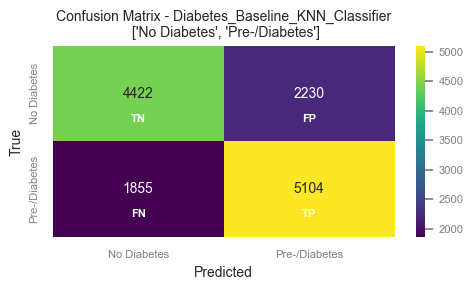


--- Generating Performance Curves ---


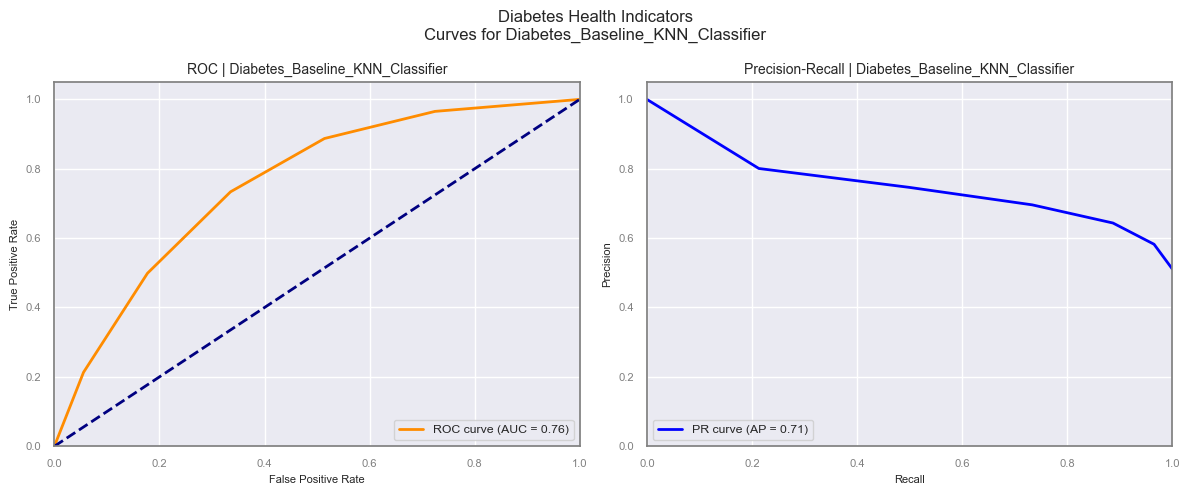

In [542]:
# VISUALIZATION: Confusion Matrix
print("\n--- Visualizing Confusion Matrix ---")
plt.figure(figsize = (5, 3))

plot_confusion_matrix(
    y_test_3a,
    diabetes_results_baseline_knn['y_pred'],
    model_name   = diabetes_results_baseline_knn['metrics']['model_name'],
    labels       = list(dict_outcome_diabetes.values()),
    ax           = plt.gca()
)
plt.show()


# ---  Model Visualization (ROC AUC and Precision-Recall) ---

print("\n--- Generating Performance Curves ---")

plt.figure(figsize = (12, 5))

# Plot 1: ROC AUC Curve using the enhanced function
plt.subplot(1, 2, 1)
plt.suptitle(f'{dataset_3a}\nCurves for {diabetes_results_baseline_knn["metrics"]["model_name"]}', fontsize=12)
plot_roc_auc_curve(
    diabetes_results_baseline_knn['classifier'],
    X_test_3a,
    y_test_3a,
    title   = f'ROC | {diabetes_results_baseline_knn["metrics"]["model_name"]}',
    ax      = plt.gca()
)

# Plot 2: Precision-Recall curve using the enhanced function
plt.subplot(1, 2, 2)
plot_precision_recall_curve(
    diabetes_results_baseline_knn['classifier'],
    X_test_3a,
    y_test_3a,
    title   = f'Precision-Recall | {diabetes_results_baseline_knn["metrics"]["model_name"]}',
    ax      = plt.gca()
)

plt.tight_layout()
plt.show()

In [543]:
metrics_diabetes_results_baseline_knn_df = pd.DataFrame(diabetes_results_baseline_knn['metrics'], index = [0])
metrics_diabetes_results_baseline_knn_df

,model_name,execution_time,mean_cv_accuracy,mean_cv_precision,mean_cv_recall,mean_cv_f1,test_accuracy
0,Diabetes_Baseline_KNN_Classifier,00:00:14,0.700608,0.698851,0.728191,0.713202,0.699875


### Diabetes | KNN - Forward Feature Selection

In [544]:
knn_model = KNeighborsClassifier(
    n_neighbors = 5,
    weights     = 'uniform',
    algorithm   = 'auto',
    leaf_size   = 30,
    p           = 1, # Manhattan distance
    n_jobs      = -1
)

diab_KNN_FFS = feature_selection(
    X               = X_train_3a,
    y               = y_train_3a,
    model           = knn_model,
    direction       = 'forward',
    scoring         = 'accuracy',  # Use a classification metric
    cv              = 5,
    tol             = 0.001,
    n_features_to_select = 10,     # Select top N features
    n_jobs          = -1,
    verbose         = True,
    exp_factor      = 1
)



Round 1:
Trying Adding feature 'CholCheck'   - Score: -0.5292
Trying Adding feature 'BMI'         - Score: -0.5866
Trying Adding feature 'PhysActivity' - Score: -0.5292
Trying Adding feature 'Fruits'      - Score: -0.5056
Trying Adding feature 'Veggies'     - Score: -0.4965
Trying Adding feature 'HvyAlcoholConsump' - Score: -0.5267
Trying Adding feature 'AnyHealthcare' - Score: -0.5142
Trying Adding feature 'NoDocbcCost' - Score: -0.5068
Trying Adding feature 'GenHlth'     - Score: -0.6490
Trying Adding feature 'DiffWalk'    - Score: -0.5113
Trying Adding feature 'Sex'         - Score: -0.5113
Trying Adding feature 'Age'         - Score: -0.5663
Trying Adding feature 'Education'   - Score: -0.5211
Trying Adding feature 'Income'      - Score: -0.5497
Trying Adding feature 'Risk_Count'  - Score: -0.5958
Trying Adding feature 'Total_Bad_Health_Days' - Score: -0.5283
Trying Adding feature 'Age_BMI_Interaction' - Score: -0.6386
Trying Adding feature 'BMI_Cat'     - Score: -0.5961

Adding '

In [545]:
diab_KNN_FFS

{'direction': 'forward',
 'selected_features_in_order': ['GenHlth',
  'Age_BMI_Interaction',
  'Risk_Count',
  'BMI',
  'CholCheck'],
 'scores_at_each_step': [np.float64(-0.6489906952320756),
  np.float64(-0.6822914637445294),
  np.float64(-0.6944509417015425),
  np.float64(-0.7020185892928367),
  np.float64(-0.705251339260802)],
 'best_feature_set_found': ['GenHlth',
  'Age_BMI_Interaction',
  'Risk_Count',
  'BMI',
  'CholCheck'],
 'best_score': np.float64(-0.705251339260802),
 'exp_factor': 1,
 'execution_time': '39.02s',
 'timestamp': '2025-11-23 10:35:34'}

#### Re-processing using best features

In [546]:
selected_features = diab_KNN_FFS['best_feature_set_found']
print(f"Selected Features ({len(selected_features)}): {selected_features}\nBest CV Score: {-1 * diab_KNN_FFS['best_score']:,.4f}")

Selected Features (5): ['GenHlth', 'Age_BMI_Interaction', 'Risk_Count', 'BMI', 'CholCheck']
Best CV Score: 0.7053


In [547]:
cols_to_keep = selected_features + ['Diabetes_binary']
diab_df_final = df_3a_engineered[cols_to_keep].copy()
diab_df_final

,GenHlth,Age_BMI_Interaction,Risk_Count,BMI,CholCheck,Diabetes_binary
0,3.0,104.0,1.0,26.0,1.0,0
1,3.0,312.0,4.0,26.0,1.0,0
2,1.0,338.0,0.0,26.0,1.0,0
3,3.0,308.0,3.0,28.0,1.0,0
4,2.0,232.0,1.0,29.0,1.0,0
...,...,...,...,...,...,...
70687,4.0,222.0,1.0,37.0,1.0,1
70688,2.0,290.0,3.0,29.0,1.0,1
70689,5.0,325.0,3.0,25.0,1.0,1
70690,4.0,198.0,2.0,18.0,1.0,1


In [548]:
X_train_opt_diab, X_test_opt_diab, y_train_opt_diab, y_test_opt_diab, X_opt_diab = prepare_data(
    df           = diab_df_final,
    target_col   = 'Diabetes_binary',
    test_size    = TEST_SIZE,
    random_state = RANDOM_STATE
)

Target variable 'Diabetes_binary' encoded successfully.
Dropped rows with NaNs and duplicates.
Initial rows: 70692, Final rows: 13492
Percentage of data retained: 19.09%

Applied type coercion to feature columns.
Data Split: Training set size = 10793, Test set size = 2699

--- Manual Feature Scaling ---
Using StandardScaler for feature scaling.
Scaling Complete.



### Diabetes | Backward Feature Selection

In [580]:
knn_model = KNeighborsClassifier(
    n_neighbors = 5,
    weights     = 'uniform',
    algorithm   = 'auto',
    leaf_size   = 30,
    p           = 1, # Manhattan distance
    n_jobs      = -1
)

diab_KNN_BFS = feature_selection(
    X               = X_train_3a,
    y               = y_train_3a,
    model           = knn_model,
    direction       = 'backward',
    scoring         = 'accuracy',  # Use a classification metric
    cv              = 5,
    tol             = 0.001,
    n_features_to_select = 10,     # Select top N features
    n_jobs          = -1,
    verbose         = True,
    exp_factor      = 1
)


Round 1:
Trying Removing feature 'CholCheck' - Score: -0.6996
Trying Removing feature 'BMI'       - Score: -0.7004
Trying Removing feature 'PhysActivity' - Score: -0.7014
Trying Removing feature 'Fruits'    - Score: -0.7027
Trying Removing feature 'Veggies'   - Score: -0.7028
Trying Removing feature 'HvyAlcoholConsump' - Score: -0.7003
Trying Removing feature 'AnyHealthcare' - Score: -0.7017
Trying Removing feature 'NoDocbcCost' - Score: -0.7018
Trying Removing feature 'GenHlth'   - Score: -0.6862
Trying Removing feature 'DiffWalk'  - Score: -0.7019
Trying Removing feature 'Sex'       - Score: -0.7020
Trying Removing feature 'Age'       - Score: -0.7006
Trying Removing feature 'Education' - Score: -0.7027
Trying Removing feature 'Income'    - Score: -0.6983
Trying Removing feature 'Risk_Count' - Score: -0.6897
Trying Removing feature 'Total_Bad_Health_Days' - Score: -0.7030
Trying Removing feature 'Age_BMI_Interaction' - Score: -0.7009
Trying Removing feature 'BMI_Cat'   - Score: -0.7

In [581]:
diab_KNN_BFS

{'direction': 'backward',
 'selected_features_in_order': ['BMI_Cat',
  'Total_Bad_Health_Days',
  'AnyHealthcare'],
 'scores_at_each_step': [np.float64(-0.7016329329243076),
  np.float64(-0.7039655621831926),
  np.float64(-0.7051594882809493),
  np.float64(-0.7062615515904292)],
 'best_feature_set_found': ['CholCheck',
  'BMI',
  'PhysActivity',
  'Fruits',
  'Veggies',
  'HvyAlcoholConsump',
  'NoDocbcCost',
  'GenHlth',
  'DiffWalk',
  'Sex',
  'Age',
  'Education',
  'Income',
  'Risk_Count',
  'Age_BMI_Interaction'],
 'best_score': np.float64(-0.7062615515904292),
 'exp_factor': 1,
 'execution_time': '3m 15.25s',
 'timestamp': '2025-11-23 10:49:02'}

In [582]:
selected_features_diab_BFS = diab_KNN_BFS['best_feature_set_found']
print(f"Selected Features ({len(selected_features_diab_BFS)}): {selected_features_diab_BFS}\nBest CV Score: {-1 * diab_KNN_BFS['best_score']:,.4f}")

Selected Features (15): ['CholCheck', 'BMI', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'NoDocbcCost', 'GenHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income', 'Risk_Count', 'Age_BMI_Interaction']
Best CV Score: 0.7063


### Diabetes | Recursive Feature Elimination

In [579]:
# start = time.time()
# # Apply Recursive Feature Elimination
# rfe        = RFE(estimator=model, n_features_to_select=10)
# rfe.fit(X_train_final, y_train)

# # Get selected feature names
# selected_features = X_train_final.columns[rfe.get_support()].tolist()
# print("Selected Features:", selected_features)

# # Subset the data
# X_train_selected    = X_train_final[selected_features]
# X_test_selected     = X_test_final[selected_features]

# # Fit the model
# model.fit(X_train_selected, y_train)
# y_pred = model.predict(X_test_selected)

# # Evaluate
# accuracy    = accuracy_score(y_test, y_pred)
# precision   = precision_score(y_test, y_pred)
# recall      = recall_score(y_test, y_pred)
# f1          = f1_score(y_test, y_pred)
# report      = classification_report(y_test, y_pred, target_names=[dict_outcome[0], dict_outcome[1]])

# print("\n--- Logistic Regression Evaluation on Selected Features (RFE) ---")
# print(f"Final Test Accuracy: {accuracy:.4f}\n")
# print("Classification Report:\n", report)


# end = time.time()
# execution_time = format_time(end - start)
# time_stamp     = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
# # Store results
# diabetes_results_logreg_RFE = {
#     'Model':       'Diabetes_LogReg_RFE',
#     'Accuracy':    accuracy,
#     'Precision':   precision,
#     'Recall':      recall,
#     'f1':          f1,
#     'execution_time': execution_time,
#     'time_stamp': time_stamp
# }


### Diabetes | KNN - GridSearchCV

In [607]:

diab_knn_param_grid = {
    # Two main weighting schemes: uniform or distance-weighted
    # Distance metrics: p=1 (Manhattan) or p=2 (Euclidean)
    # Algorithm: 'auto' chooses the best tree/brute-force implementation
    'n_neighbors':  list(range(20, 300, 20)),
    'weights':      ['uniform', 'distance'],
    'p':            [1, 2],
    'algorithm':    ['auto']
}

Using HalvingGridSearchCV with halving factor 2...
n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 337
max_resources_: 10793
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 56
n_resources: 337
Fitting 5 folds for each of 56 candidates, totalling 280 fits


/Users/arunram/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/arunram/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/arunram/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/arunram/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^

----------
iter: 1
n_candidates: 28
n_resources: 674
Fitting 5 folds for each of 28 candidates, totalling 140 fits


/Users/arunram/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1135: UserWarning: One or more of the test scores are non-finite: [0.62089552 0.6        0.62985075 0.60597015 0.62686567 0.60597015
 0.60895522 0.58507463 0.63880597 0.60597015 0.63880597 0.63283582
 0.64477612 0.61492537 0.63880597 0.6238806  0.65373134 0.62089552
 0.63880597 0.6358209  0.64776119 0.63283582 0.6238806  0.6238806
 0.62686567 0.6119403  0.62985075 0.61791045 0.66567164 0.62686567
 0.66268657 0.63283582 0.65373134 0.63283582 0.6238806  0.62985075
 0.62686567 0.63880597 0.61791045 0.61791045 0.62985075 0.62985075
 0.62985075 0.62686567 0.60597015 0.62686567 0.60298507 0.62089552
 0.59104478 0.6238806  0.59701493 0.6119403         nan        nan
        nan        nan 0.6358209  0.61940299 0.63283582 0.6119403
 0.61791045 0.61641791 0.63432836 0.61492537 0.62089552 0.62089552
 0.63432836 0.61791045 0.61940299 0.60895522 0.63134328 0.61044776
 0.61940299 0.62985075 0.63880

----------
iter: 2
n_candidates: 14
n_resources: 1348
Fitting 5 folds for each of 14 candidates, totalling 70 fits


/Users/arunram/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1135: UserWarning: One or more of the test scores are non-finite: [0.62089552 0.6        0.62985075 0.60597015 0.62686567 0.60597015
 0.60895522 0.58507463 0.63880597 0.60597015 0.63880597 0.63283582
 0.64477612 0.61492537 0.63880597 0.6238806  0.65373134 0.62089552
 0.63880597 0.6358209  0.64776119 0.63283582 0.6238806  0.6238806
 0.62686567 0.6119403  0.62985075 0.61791045 0.66567164 0.62686567
 0.66268657 0.63283582 0.65373134 0.63283582 0.6238806  0.62985075
 0.62686567 0.63880597 0.61791045 0.61791045 0.62985075 0.62985075
 0.62985075 0.62686567 0.60597015 0.62686567 0.60298507 0.62089552
 0.59104478 0.6238806  0.59701493 0.6119403         nan        nan
        nan        nan 0.6358209  0.61940299 0.63283582 0.6119403
 0.61791045 0.61641791 0.63432836 0.61492537 0.62089552 0.62089552
 0.63432836 0.61791045 0.61940299 0.60895522 0.63134328 0.61044776
 0.61940299 0.62985075 0.63880

----------
iter: 3
n_candidates: 7
n_resources: 2696
Fitting 5 folds for each of 7 candidates, totalling 35 fits


/Users/arunram/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1135: UserWarning: One or more of the test scores are non-finite: [0.62089552 0.6        0.62985075 0.60597015 0.62686567 0.60597015
 0.60895522 0.58507463 0.63880597 0.60597015 0.63880597 0.63283582
 0.64477612 0.61492537 0.63880597 0.6238806  0.65373134 0.62089552
 0.63880597 0.6358209  0.64776119 0.63283582 0.6238806  0.6238806
 0.62686567 0.6119403  0.62985075 0.61791045 0.66567164 0.62686567
 0.66268657 0.63283582 0.65373134 0.63283582 0.6238806  0.62985075
 0.62686567 0.63880597 0.61791045 0.61791045 0.62985075 0.62985075
 0.62985075 0.62686567 0.60597015 0.62686567 0.60298507 0.62089552
 0.59104478 0.6238806  0.59701493 0.6119403         nan        nan
        nan        nan 0.6358209  0.61940299 0.63283582 0.6119403
 0.61791045 0.61641791 0.63432836 0.61492537 0.62089552 0.62089552
 0.63432836 0.61791045 0.61940299 0.60895522 0.63134328 0.61044776
 0.61940299 0.62985075 0.63880

----------
iter: 4
n_candidates: 4
n_resources: 5392
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/arunram/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1135: UserWarning: One or more of the test scores are non-finite: [0.62089552 0.6        0.62985075 0.60597015 0.62686567 0.60597015
 0.60895522 0.58507463 0.63880597 0.60597015 0.63880597 0.63283582
 0.64477612 0.61492537 0.63880597 0.6238806  0.65373134 0.62089552
 0.63880597 0.6358209  0.64776119 0.63283582 0.6238806  0.6238806
 0.62686567 0.6119403  0.62985075 0.61791045 0.66567164 0.62686567
 0.66268657 0.63283582 0.65373134 0.63283582 0.6238806  0.62985075
 0.62686567 0.63880597 0.61791045 0.61791045 0.62985075 0.62985075
 0.62985075 0.62686567 0.60597015 0.62686567 0.60298507 0.62089552
 0.59104478 0.6238806  0.59701493 0.6119403         nan        nan
        nan        nan 0.6358209  0.61940299 0.63283582 0.6119403
 0.61791045 0.61641791 0.63432836 0.61492537 0.62089552 0.62089552
 0.63432836 0.61791045 0.61940299 0.60895522 0.63134328 0.61044776
 0.61940299 0.62985075 0.63880

----------
iter: 5
n_candidates: 2
n_resources: 10784
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/Users/arunram/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1135: UserWarning: One or more of the test scores are non-finite: [0.62089552 0.6        0.62985075 0.60597015 0.62686567 0.60597015
 0.60895522 0.58507463 0.63880597 0.60597015 0.63880597 0.63283582
 0.64477612 0.61492537 0.63880597 0.6238806  0.65373134 0.62089552
 0.63880597 0.6358209  0.64776119 0.63283582 0.6238806  0.6238806
 0.62686567 0.6119403  0.62985075 0.61791045 0.66567164 0.62686567
 0.66268657 0.63283582 0.65373134 0.63283582 0.6238806  0.62985075
 0.62686567 0.63880597 0.61791045 0.61791045 0.62985075 0.62985075
 0.62985075 0.62686567 0.60597015 0.62686567 0.60298507 0.62089552
 0.59104478 0.6238806  0.59701493 0.6119403         nan        nan
        nan        nan 0.6358209  0.61940299 0.63283582 0.6119403
 0.61791045 0.61641791 0.63432836 0.61492537 0.62089552 0.62089552
 0.63432836 0.61791045 0.61940299 0.60895522 0.63134328 0.61044776
 0.61940299 0.62985075 0.63880


Best Parameters: {'algorithm': 'auto', 'n_neighbors': 160, 'p': 2, 'weights': 'uniform'}
Best CV Score (accuracy): 0.6233
Test Accuracy: 0.6258
Execution Time: 00:00:02 seconds
Completed at: 2025-11-23 11:04:06

KNeighborsClassifier - HalvingGridSearchCV
Classification Report:
              precision    recall  f1-score   support

           0     0.6369    0.5898    0.6124      1353
           1     0.6162    0.6620    0.6383      1346

    accuracy                         0.6258      2699
   macro avg     0.6265    0.6259    0.6253      2699
weighted avg     0.6266    0.6258    0.6253      2699

Train Accuracy: 0.6352
Test Accuracy: 0.6258


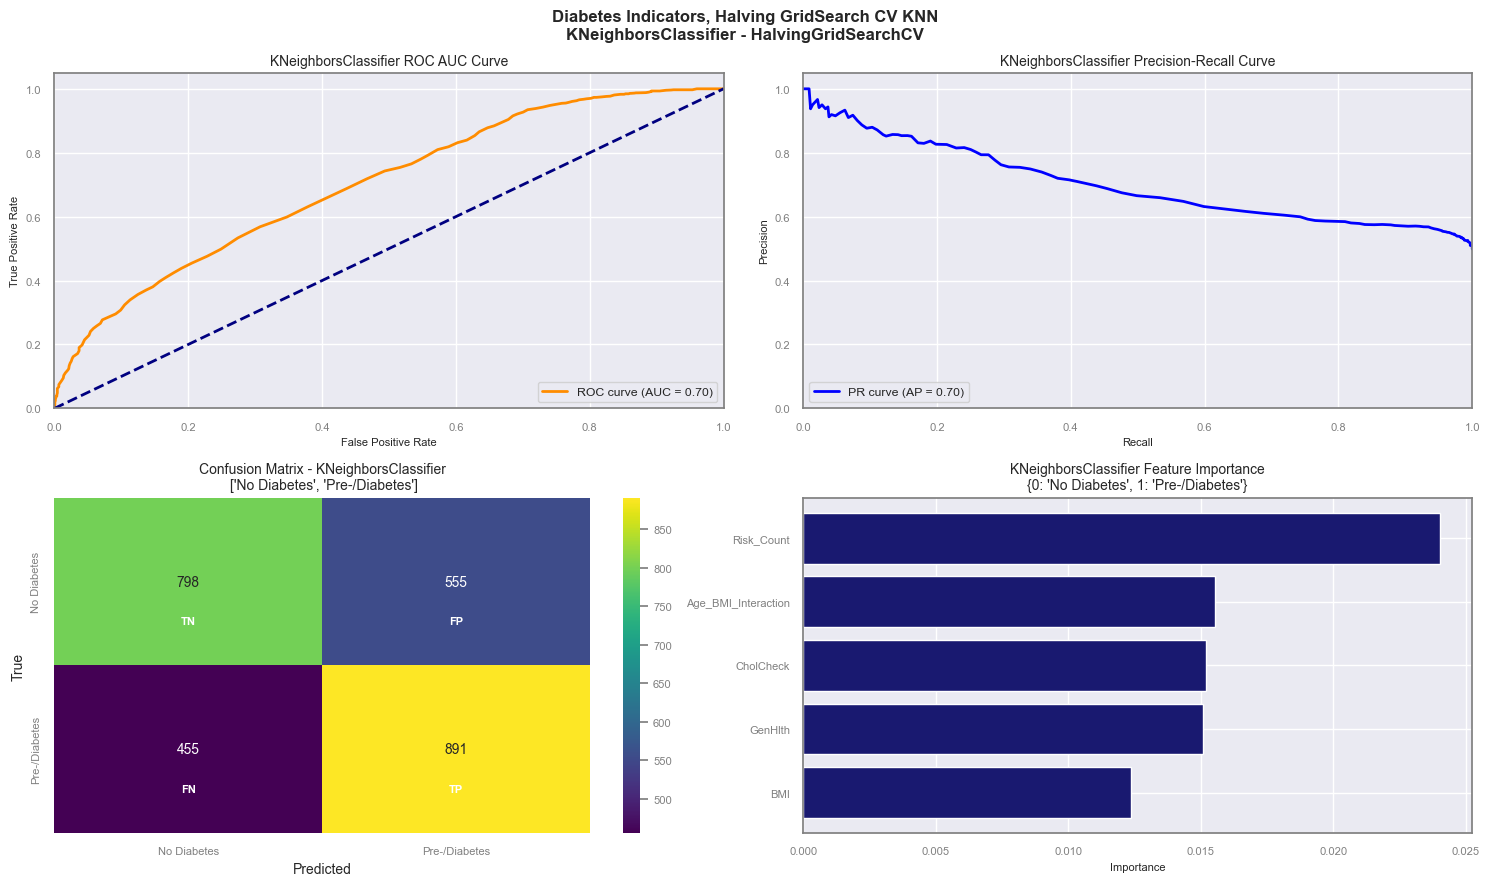

<Figure size 640x480 with 0 Axes>

In [608]:
results_diab_KNN_gridCV = run_GridSearch_RandomizedSearch_CV(
    ensemble_model       = KNeighborsClassifier,
    dataset_name         = 'Diabetes Indicators, Halving GridSearch CV KNN',
    parameter_grid       = diab_knn_param_grid,
    X                    = X_opt_diab,
    X_train              = X_train_opt_diab,
    y_train              = y_train_opt_diab,
    X_test               = X_test_opt_diab,
    y_test               = y_test_opt_diab,
    classification_dict  = dict_outcome_diabetes,
    CV_tuning_strategy   = 1,  # HalvingGridSearchCV
    iterations           = 10,
    cv_folds             = 5,
    random_state         = RANDOM_STATE,  
    scoring_metric       = 'accuracy'
)

best_params_knn_diab_df = results_diab_KNN_gridCV[0]

In [609]:
best_params_knn_diab_df

,algorithm,n_neighbors,p,weights,Dataset,Model,Strategy,Scoring_Metric,Best_CV_Score,test_accuracy,execution_time,timestamp
0,auto,160,2,uniform,"Diabetes Indicators, Halving GridSearch CV KNN",KNeighborsClassifier,HalvingGridSearchCV,accuracy,0.623295,0.625787,00:00:02,2025-11-23 11:04:06


In [610]:
cv_results_knn_diab_df = results_diab_KNN_gridCV[1]
# cv_results_knn_diab_df  

In [611]:
summary_diab_knn_df = pd.concat(
    [metrics_diabetes_results_baseline_knn_df, best_params_knn_diab_df],
    ignore_index = True,
    sort         = False
)

summary_diab_knn_df

,model_name,execution_time,mean_cv_accuracy,mean_cv_precision,mean_cv_recall,mean_cv_f1,test_accuracy,algorithm,n_neighbors,p,weights,Dataset,Model,Strategy,Scoring_Metric,Best_CV_Score,timestamp
0,Diabetes_Baseline_KNN_Classifier,00:00:14,0.700608,0.698851,0.728191,0.713202,0.699875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,00:00:02,NaN,NaN,NaN,NaN,0.625787,auto,160.0,2.0,uniform,"Diabetes Indicators, Halving GridSearch CV KNN",KNeighborsClassifier,HalvingGridSearchCV,accuracy,0.623295,2025-11-23 11:04:06


This dataset is notoriously "noisy," meaning there is a high degree of overlap between the two classes.

### 1. "Class Overlap" Problem
KNN assumes that data points close to each other in geometric space share the same label. However, in health survey data there can be people with nearly identical profiles (e.g., both Overweight, Smoker, Age 50), but due to genetics or unmeasured factors, one has diabetes and the other does not.
* If a Diabetic patient is surrounded by 3 Non-Diabetics with similar BMIs and Ages, KNN will confidently misclassify them.
* Grid Search chose **30 Neighbors** (`n_neighbors=30`). A high $K$ value usually indicates that the local data is noisy; the model has to "zoom out" to get a consensus, sacrificing local detail to drown out the noise.


### 2. Curse of Dimensionality
KNN calculates distance in $N$-dimensional space; the diabetes dataset originally had 21 features, so 21-D space...  
* As dimensions increase, the "distance" between points becomes less meaningful. All points tend to become roughly equidistant from one another in high-dimensional space, making it hard for the algorithm to distinguish "near" neighbors from "far" ones.
* **Forward Feature Selection (FFS)** output shows that accuracy plateaued (and even degraded) after adding just a few features; the model got confused by the additional noise rather than helped by the extra data.

### 3. Mixed Feature Scales (Numeric vs. Binary)
Your preprocessing (Cell 49) was logically sound but creates a specific challenge for KNN:
* **Numeric Features (BMI, Age):** Scaled using `StandardScaler` (Mean=0, Variance=1).
* **Binary Features (Smoker, HighBP):** Left as 0 or 1.

**The conflict:** In Euclidean distance calculations, a feature with larger variance dominates the distance score. The binary features have a max distance of 1.0,but the scaled numeric features can have distances of 4.0 or more (e.g., an outlier BMI vs. low BMI). KNN might be prioritizing BMI and Age simply because they cover more "geometric distance," ignoring critical binary flags like `HeartDiseaseorAttack`.

### 4. Manhattan vs. Euclidean Distance
Grid Search  selected `p=1` (**Manhattan Distance**) as the best parameter, beating the default Euclidean (`p=2`).

* Manhattan distance is often better for high-dimensional data and datasets containing many binary attributes (like HighBP, HighChol, Smoker). It calculates distance by traveling along the grid lines (like a taxi in a city) rather than "as the crow flies," which tends to be more robust against the scaling issues mentioned in point #3.

In [554]:
# from sklearn.decomposition import PCA
# from sklearn.pipeline import Pipeline

# # Define a pipeline: Scale -> PCA -> KNN
# # We perform scaling inside the pipeline to prevent data leakage
# pca_pipeline = Pipeline([
#     ('scaler', StandardScaler()),       # KNN requires scaling
#     ('pca', PCA(n_components = 0.95)),    # Keep enough components to explain 95% of variance
#     ('knn', KNeighborsClassifier(n_neighbors = 29, p = 1, weights = 'uniform')) # Your best params
# ])

# # Fit and Predict
# print("--- Running KNN with PCA ---")
# # pca_pipeline.fit(X_train, y_train)
# y_pred_pca = pca_pipeline.predict(X_test)

# # Evaluate
# acc_pca = accuracy_score(y_test, y_pred_pca)
# print(f"Test Accuracy with PCA: {acc_pca:.4f}")

## <font color='plum'> 3.c. Chronic Kidney Disease Dataset

Contains comprehensive data for 1,659 patients, including 54 variables spanning medical history, lab results, medication usage, quality of life, and environmental
exposure. Ideal for regression, classification, and clustering analyses.
https://www.kaggle.com/datasets/rabieelkharoua/chronic-kidney-disease-dataset-analysis

### Load & Clean - CKD

In [583]:
file_path  = "rabieelkharoua/chronic-kidney-disease-dataset-analysis"
file_name  = "Chronic_Kidney_Dsease_data.csv"
dataset_3c = 'Chronic Kidney Disease Prediction'

# Load the latest version
df_3c = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  file_path,
  file_name,
)

df_3c.columns       = df_3c.columns.str.strip()
columns_to_drop     = ['PatientID', 'DoctorInCharge']
df_3c.drop(columns  = columns_to_drop, inplace = True, errors = 'ignore')

# for stupid confusion matrix plot
classification_dict_CKD = {
    0: 'No CKD',
    1: 'CKD'
}



In [584]:
df_3c

,Age,Gender,Ethnicity,SocioeconomicStatus,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MuscleCramps,Itching,QualityOfLifeScore,HeavyMetalsExposure,OccupationalExposureChemicals,WaterQuality,MedicalCheckupsFrequency,MedicationAdherence,HealthLiteracy,Diagnosis
0,71,0,0,0,2,31.069414,1,5.128112,1.676220,0.240386,...,4.518513,7.556302,76.076800,0,0,1,1.018824,4.966808,9.871449,1
1,34,0,0,1,3,29.692119,1,18.609552,8.377574,6.503233,...,2.202222,6.836766,40.128498,0,0,0,3.923538,8.189275,7.161765,1
2,80,1,1,0,1,37.394822,1,11.882429,9.607401,2.104828,...,5.967271,2.144722,92.872842,0,1,1,1.429906,7.624028,7.354632,1
3,40,0,2,0,1,31.329680,0,16.020165,0.408871,6.964422,...,2.176387,7.077188,90.080321,0,0,0,3.226416,3.282688,6.629587,1
4,43,0,1,1,2,23.726311,0,7.944146,0.780319,3.097796,...,6.800993,3.553118,5.258372,0,0,1,0.285466,3.849498,1.437385,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654,90,0,0,1,2,39.677059,1,1.370151,4.157954,8.602873,...,6.972093,2.138976,81.102765,0,0,0,0.951836,9.547583,2.046212,0
1655,34,0,0,2,1,28.922015,0,3.372073,9.647525,9.836919,...,0.465297,7.911566,10.600428,0,1,0,3.604147,1.609847,0.324417,0
1656,84,0,0,2,3,21.951219,0,15.825955,7.349964,5.038194,...,2.281970,0.015531,69.633427,0,0,0,0.801955,5.768617,4.935108,0
1657,90,0,0,2,2,24.964149,0,12.967462,0.618614,4.557577,...,0.257814,3.432765,31.858023,0,0,0,0.560298,2.744519,0.322592,1


In [585]:
# show distribution of target variable
df_3c['Diagnosis'].value_counts()

Diagnosis
1    1524
0     135
Name: count, dtype: int64

In [586]:

CKD_engineered_df = engineer_features_ckd(df_3c)

# Check the new shape
print(f"Original Feature Count: {df_3c.shape[1]}")
print(f"New Feature Count: {CKD_engineered_df.shape[1]}")

Original Feature Count: 52
New Feature Count: 37


In [587]:
CKD_engineered_df

,Age,Gender,Ethnicity,SocioeconomicStatus,EducationLevel,PhysicalActivity,DietQuality,SleepQuality,PreviousAcuteKidneyInjury,UrinaryTractInfections,...,Diagnosis,BUN_Creatinine_Ratio,Cholesterol_Ratio,MAP,FamilyHistoryScore,ExposureScore,Symptom_Score,Lifestyle_Risk_Score,Metabolic_Stress,Electrolyte_Homeostasis_Score
0,71,0,0,0,2,1.676220,0.240386,4.076434,0,0,...,1,5.159857,9.451682,93.000000,0,0,22.630953,1.256499,2.545740e+05,4.351878
1,34,0,0,1,3,8.377574,6.503233,7.652813,0,0,...,1,9.927197,2.163179,84.666667,2,0,14.722613,1.930817,3.593300e+05,3.374655
2,80,1,1,0,1,9.607401,2.104828,4.392786,0,0,...,1,10.745169,14.164531,119.666667,0,1,17.641482,1.594338,8.849652e+05,3.493184
3,40,0,2,0,1,0.408871,6.964422,6.282274,0,0,...,1,7.662962,4.034854,82.333333,0,0,23.476715,0.801300,6.909847e+05,3.942641
4,43,0,1,1,2,0.780319,3.097796,4.021639,0,0,...,1,3.081146,11.961053,76.666667,0,0,14.049889,0.397352,1.910290e+05,2.625237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654,90,0,0,1,2,4.157954,8.602873,5.239288,0,0,...,0,10.590084,5.977452,102.666667,0,0,17.626082,1.068533,1.008050e+06,3.524392
1655,34,0,0,2,1,9.647525,9.836919,6.401662,0,0,...,0,46.431262,9.338641,111.000000,0,1,14.066795,0.168665,2.703637e+05,3.834765
1656,84,0,0,2,3,7.349964,5.038194,8.440859,0,0,...,0,56.374587,4.266000,107.333333,0,0,12.896617,0.791586,4.224282e+05,4.776729
1657,90,0,0,2,2,0.618614,4.557577,5.527100,0,0,...,1,11.124152,9.996976,112.333333,0,0,9.687011,0.648609,4.020096e+05,4.092358


In [588]:

X_train_CKD, X_test_CKD, y_train_CKD, y_test_CKD, X_CKD = prepare_data(
    df              = CKD_engineered_df,
    # df              = df_3c,    
    target_col      = 'Diagnosis',
    test_size       = TEST_SIZE,
    random_state    = RANDOM_STATE
)


print("X_train:", X_train_CKD.shape)
print("y_train:", y_train_CKD.shape)
print("X_test:", X_test_CKD.shape)
print("y_test:", y_test_CKD.shape)
print(f'Updated feature list: {X_CKD.columns.tolist()}\n')

Target variable 'Diagnosis' encoded successfully.
Dropped rows with NaNs and duplicates.
Initial rows: 1659, Final rows: 1659
Percentage of data retained: 100.00%

Applied type coercion to feature columns.
Data Split: Training set size = 1327, Test set size = 332

--- Manual Feature Scaling ---
Using StandardScaler for feature scaling.
Scaling Complete.

X_train: (1327, 36)
y_train: (1327,)
X_test: (332, 36)
y_test: (332,)
Updated feature list: ['Age', 'Gender', 'Ethnicity', 'SocioeconomicStatus', 'EducationLevel', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'PreviousAcuteKidneyInjury', 'UrinaryTractInfections', 'FastingBloodSugar', 'HbA1c', 'SerumCreatinine', 'GFR', 'ProteinInUrine', 'ACR', 'HemoglobinLevels', 'ACEInhibitors', 'Diuretics', 'NSAIDsUse', 'Statins', 'AntidiabeticMedications', 'QualityOfLifeScore', 'WaterQuality', 'MedicalCheckupsFrequency', 'MedicationAdherence', 'HealthLiteracy', 'BUN_Creatinine_Ratio', 'Cholesterol_Ratio', 'MAP', 'FamilyHistoryScore', 'ExposureS

In [589]:
X_train_CKD 

,Age,Gender,Ethnicity,SocioeconomicStatus,EducationLevel,PhysicalActivity,DietQuality,SleepQuality,PreviousAcuteKidneyInjury,UrinaryTractInfections,...,HealthLiteracy,BUN_Creatinine_Ratio,Cholesterol_Ratio,MAP,FamilyHistoryScore,ExposureScore,Symptom_Score,Lifestyle_Risk_Score,Metabolic_Stress,Electrolyte_Homeostasis_Score
0,0.523781,0.960827,-0.709804,0.018363,-1.864937,0.484468,0.110918,0.484914,-0.332356,-0.517137,...,0.673858,-0.910583,-0.226834,-0.987122,-0.982176,-0.402099,0.038518,0.046504,-0.681209,-1.260201
1,0.133327,-1.040770,-0.709804,-1.264179,0.331931,-1.312386,-0.714586,0.423080,-0.332356,-0.517137,...,-1.635955,-0.763499,-0.820891,-0.681705,0.402890,-0.402099,0.436620,0.147651,0.635789,-1.214774
2,-0.208321,0.960827,-0.709804,0.018363,-0.766503,1.052377,1.126446,-0.662127,-0.332356,1.933723,...,0.404778,1.782698,-0.681452,0.586951,0.402890,-0.402099,-0.391371,-1.260260,-0.248153,1.726691
3,1.011849,-1.040770,1.273164,-1.264179,0.331931,-1.665017,0.741256,-0.368443,-0.332356,-0.517137,...,1.198408,0.485112,-1.191933,1.526696,0.402890,-0.402099,0.280969,1.329937,-0.808114,-0.283922
4,-1.184457,-1.040770,-0.709804,0.018363,0.331931,1.416683,1.680456,-0.092004,-0.332356,-0.517137,...,-1.295117,-0.884406,2.291011,-1.175071,-0.982176,-0.402099,-1.522024,-1.225834,-1.269795,1.390204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1322,1.402304,-1.040770,-0.709804,0.018363,-0.766503,-1.592454,1.586834,1.630943,-0.332356,-0.517137,...,0.351117,-0.590492,1.089338,1.409228,0.402890,-0.402099,0.963097,-0.053103,0.190499,-0.039694
1323,1.011849,-1.040770,-0.709804,0.018363,1.430365,0.748188,-1.222344,-0.337496,-0.332356,-0.517137,...,1.417422,0.432360,-0.344794,-1.785905,-0.982176,-0.402099,0.163976,0.277730,-1.053981,2.046780
1324,-0.745196,-1.040770,-0.709804,1.300906,0.331931,-1.384643,-0.489024,1.106563,-0.332356,-0.517137,...,-0.811039,-0.765333,-0.046515,-1.292539,0.402890,-0.402099,-0.754555,-0.689417,0.522536,2.088047
1325,-1.428491,0.960827,0.281680,0.018363,-0.766503,0.909953,1.326063,-1.365592,-0.332356,1.933723,...,0.845767,-0.912275,-0.105958,0.117079,0.402890,-0.402099,-1.144009,-0.042219,-0.962555,-1.641551


In [590]:
# check for class imbalance
print("Class distribution in training set:")
print(y_train_CKD.value_counts(normalize = True))


Class distribution in training set:
Diagnosis
1    0.918613
0    0.081387
Name: proportion, dtype: float64


### CKD | KNN - Baseline

In [591]:
# Run KNN Classifier with manually preprocessed data
results_CKD_baseline_knn = run_knn_classifier(
    X_train      = X_train_CKD,
    y_train      = y_train_CKD,
    X_test       = X_test_CKD,
    y_test       = y_test_CKD,
    model_name   = 'CKD_Baseline_KNN_Classifier',
    dict_outcome = classification_dict_CKD,
    n_neighbors  = 5,         
    weights      = 'distance', #  'distance' for weighted voting
    p            = 1,         # 2 = Euclidean, 1 = Manhattan
    n_jobs       = -1,
    n_splits     = 5,
    n_repeats    = 10,
    is_imbalanced = True,
    random_state  = RANDOM_STATE
)


--- CKD_Baseline_KNN_Classifier Evaluation ---
Dataset is imbalanced. Using balanced_accuracy_score.
Consider SMOTE or class weighting for better performance.

Test Accuracy: 0.5185

Confusion Matrix (Test Set)
         No CKD  CKD
No CKD       1   26
CKD          0  305 

Classification Report (Test Set)
              precision    recall  f1-score   support

      No CKD       1.00      0.04      0.07        27
         CKD       0.92      1.00      0.96       305

    accuracy                           0.92       332
   macro avg       0.96      0.52      0.52       332
weighted avg       0.93      0.92      0.89       332
 

Mean CV Accuracy:
Model correctly classifies ~ 0.916 of instances across 50 different training-validation splits.

Mean CV Precision:
When model predicts the positive class, it's correct ~ 0.919 of the time.

Mean CV Recall:
Model correctly identifies ~ 0.996 of all actual positive cases (True Positives).

Mean CV F1 Score:
Harmonic mean of precision and recall

In [592]:
metrics_results_CKD_baseline_knn_df = pd.DataFrame(results_CKD_baseline_knn['metrics'], index = [0])
metrics_results_CKD_baseline_knn_df

,model_name,execution_time,mean_cv_accuracy,mean_cv_precision,mean_cv_recall,mean_cv_f1,test_accuracy
0,CKD_Baseline_KNN_Classifier,00:00:01,0.916056,0.919244,0.996157,0.956089,0.518519


### CKD | KNN - Forward Feature Selection

In [593]:
knn_model = KNeighborsClassifier(
    n_neighbors = 5,
    weights     = 'uniform',
    algorithm   = 'auto',
    leaf_size   = 30,
    p           = 1, # Manhattan distance
    n_jobs      = -1
)

CKD_KNN_FFS = feature_selection(
    X               = X_train_CKD,
    y               = y_train_CKD,
    model           = knn_model,
    direction       = 'forward',
    scoring         = 'f1_macro',  # Use a classification metric
    cv              = 5,
    tol             = 0.001,
    n_features_to_select = 10,     # Select top N features
    n_jobs          = -1,
    verbose         = True,
    exp_factor      = 1
)



Round 1:
Trying Adding feature 'Age'         - Score: -0.4776
Trying Adding feature 'Gender'      - Score: -0.4697
Trying Adding feature 'Ethnicity'   - Score: -0.4735
Trying Adding feature 'SocioeconomicStatus' - Score: -0.4453
Trying Adding feature 'EducationLevel' - Score: -0.4705
Trying Adding feature 'PhysicalActivity' - Score: -0.5024
Trying Adding feature 'DietQuality' - Score: -0.4776
Trying Adding feature 'SleepQuality' - Score: -0.4782
Trying Adding feature 'PreviousAcuteKidneyInjury' - Score: -0.4102
Trying Adding feature 'UrinaryTractInfections' - Score: -0.4375
Trying Adding feature 'FastingBloodSugar' - Score: -0.4912
Trying Adding feature 'HbA1c'       - Score: -0.4869
Trying Adding feature 'SerumCreatinine' - Score: -0.5143
Trying Adding feature 'GFR'         - Score: -0.4958
Trying Adding feature 'ProteinInUrine' - Score: -0.5051
Trying Adding feature 'ACR'         - Score: -0.4778
Trying Adding feature 'HemoglobinLevels' - Score: -0.4784
Trying Adding feature 'ACEInh

In [594]:
CKD_KNN_FFS

{'direction': 'forward',
 'selected_features_in_order': ['SerumCreatinine',
  'GFR',
  'BUN_Creatinine_Ratio',
  'Diuretics'],
 'scores_at_each_step': [np.float64(-0.5142518504972355),
  np.float64(-0.5856309741225908),
  np.float64(-0.6575023416374661),
  np.float64(-0.6709639047070102)],
 'best_feature_set_found': ['SerumCreatinine',
  'GFR',
  'BUN_Creatinine_Ratio',
  'Diuretics'],
 'best_score': np.float64(-0.6709639047070102),
 'exp_factor': 1,
 'execution_time': '4.63s',
 'timestamp': '2025-11-23 11:01:51'}

#### Re-processing using best features

In [595]:
selected_features = CKD_KNN_FFS['best_feature_set_found']
print(f"Selected Features ({len(selected_features)}): {selected_features}\nBest CV Score: {-1 * CKD_KNN_FFS['best_score']:,.4f}")

Selected Features (4): ['SerumCreatinine', 'GFR', 'BUN_Creatinine_Ratio', 'Diuretics']
Best CV Score: 0.6710


In [596]:
cols_to_keep = selected_features + ['Diagnosis']
CKD_df_final = CKD_engineered_df[cols_to_keep].copy()
CKD_df_final

,SerumCreatinine,GFR,BUN_Creatinine_Ratio,Diuretics,Diagnosis
0,4.962531,45.703204,5.159857,0,1
1,3.156799,55.784504,9.927197,0,1
2,3.698236,67.559032,10.745169,1,1
3,2.868468,33.202542,7.662962,0,1
4,3.964877,56.319082,3.081146,1,1
...,...,...,...,...,...
1654,2.191402,80.644448,10.590084,1,0
1655,0.584633,118.026779,46.431262,0,0
1656,0.527432,19.283249,56.374587,1,0
1657,1.417972,68.770181,11.124152,0,1


In [597]:
X_train_opt_CKD, X_test_opt_CKD, y_train_opt_CKD, y_test_opt_CKD, X_opt_CKD = prepare_data(
    df           = CKD_df_final,
    target_col   = 'Diagnosis',
    test_size    = TEST_SIZE,
    random_state = RANDOM_STATE
)

Target variable 'Diagnosis' encoded successfully.
Dropped rows with NaNs and duplicates.
Initial rows: 1659, Final rows: 1659
Percentage of data retained: 100.00%

Applied type coercion to feature columns.
Data Split: Training set size = 1327, Test set size = 332

--- Manual Feature Scaling ---
Using StandardScaler for feature scaling.
Scaling Complete.



### CKD | KNN - GridSearchCV

In [598]:
from imblearn.over_sampling import SMOTE

print(f"Original Training Class Distribution: \n{y_train_opt_CKD.value_counts()}")

# 1. Initialize SMOTE
smote = SMOTE(random_state = RANDOM_STATE)

# 2. Resample the training data ONLY
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_opt_CKD, y_train_opt_CKD)
print(f"Resampled Training Class Distribution: \n{y_train_resampled.value_counts()}")
# expecting equal numbers for both classes (e.g., 1000 vs 1000)

Original Training Class Distribution: 
Diagnosis
1    1219
0     108
Name: count, dtype: int64
Resampled Training Class Distribution: 
Diagnosis
1    1219
0    1219
Name: count, dtype: int64


In [599]:

CKD_knn_param_grid = {
    # Two main weighting schemes: uniform or distance-weighted
    # Distance metrics: p=1 (Manhattan) or p=2 (Euclidean)
    # Algorithm: 'auto' chooses the best tree/brute-force implementation
    'n_neighbors':  list(range(50, 300, 25)),
    'weights':      ['uniform', 'distance'],
    'p':            [1, 2],
    'algorithm':    ['auto']
}

Using GridSearchCV...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best Parameters: {'algorithm': 'auto', 'n_neighbors': 50, 'p': 2, 'weights': 'distance'}
Best CV Score (f1_macro): 0.8133
Test Accuracy: 0.7470
Execution Time: 00:00:01 seconds
Completed at: 2025-11-23 11:01:53

KNeighborsClassifier - GridSearchCV
Classification Report:
              precision    recall  f1-score   support

           0     0.1935    0.6667    0.3000        27
           1     0.9623    0.7541    0.8456       305

    accuracy                         0.7470       332
   macro avg     0.5779    0.7104    0.5728       332
weighted avg     0.8998    0.7470    0.8012       332

Train Accuracy: 1.0000
Test Accuracy: 0.7470


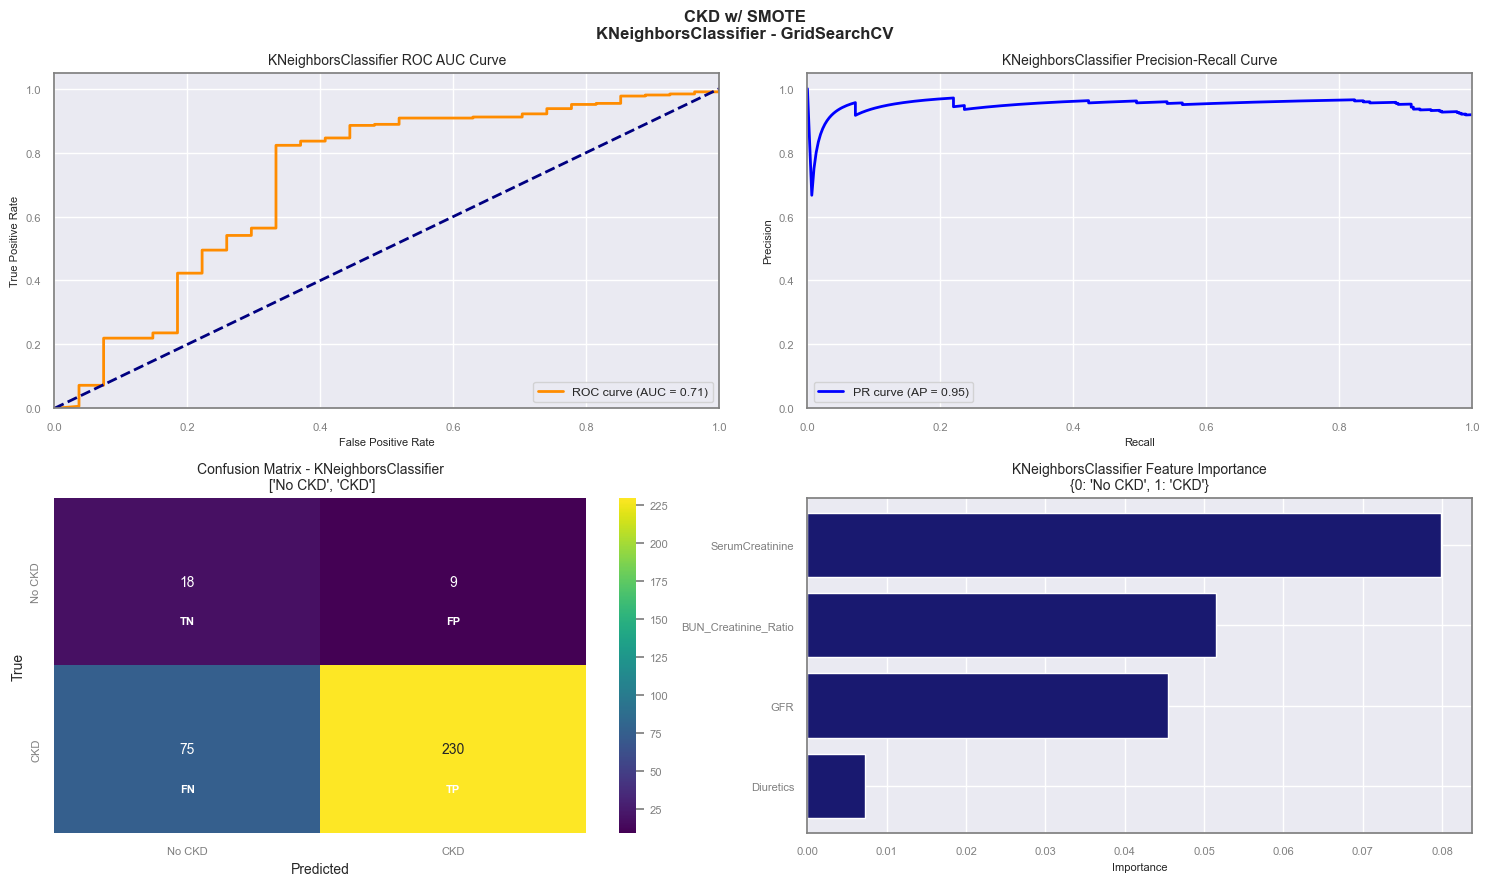

<Figure size 640x480 with 0 Axes>

In [600]:
results_CKD_KNN_gridCV = run_GridSearch_RandomizedSearch_CV(
    ensemble_model       = KNeighborsClassifier,
    dataset_name         = 'CKD w/ SMOTE',
    parameter_grid       = CKD_knn_param_grid,
    X                    = CKD_df_final.drop(columns = ['Diagnosis']),
    X_train              = X_train_resampled,
    y_train              = y_train_resampled,
    X_test               = X_test_opt_CKD,
    y_test               = y_test_opt_CKD,
    classification_dict  = classification_dict_CKD,
    CV_tuning_strategy   = 2,  # GridSearchCV
    iterations           = 10,
    cv_folds             = 5,
    random_state         = RANDOM_STATE,  
    scoring_metric       = 'f1_macro'
)

best_params_CKD_knn_df = results_CKD_KNN_gridCV[0]

In [601]:
best_params_CKD_knn_df

,algorithm,n_neighbors,p,weights,Dataset,Model,Strategy,Scoring_Metric,Best_CV_Score,test_accuracy,execution_time,timestamp
0,auto,50,2,distance,CKD w/ SMOTE,KNeighborsClassifier,GridSearchCV,f1_macro,0.813294,0.746988,00:00:01,2025-11-23 11:01:53


<font color = 'plum'>

1. The Breakthrough: Recall (Sensitivity)
* **Previous Model:** Recall for "No CKD" (Class 0) was **0.00**. It found *zero* healthy patients.
* **This Model:** Recall for "No CKD" is **0.67**. It successfully identified **two-thirds** of the healthy patients.

**Why this matters:** The model no longer just guesses "Sick" for everyone. SMOTE successfully forced it to learn the patterns of a healthy kidney, proving that engineered features (like `BUN_Creatinine_Ratio`) contain real, usable signals.

2. The Trade-off: Precision vs. Accuracy
Accuracy dropped from **92%** to **74.7%**. This was expected:
* **The Drop:** The "lazy" model was right 92% of the time by doing nothing. To find the healthy people, the new model had to take risks.
    * **The Cost (Precision):** The Precision for Class 0 is low (**0.19**), meaning that in its eagerness to find healthy people, it flagged a lot of sick people as "healthy" by mistake.
        * *Translation:* If this model says you are healthy, there is only a ~19% chance it's right.
    * *Cause:* This is a side effect of SMOTE with a distance-based algorithm like KNN. The synthetic data blurred the decision boundary, causing the "Healthy" region to bleed into the "Sick" region.

3. Why `n_neighbors=50` and `weights='distance'`?
The grid search selected **50 neighbors** with **distance weighting**.
* **K=50:** The data is extremely noisy; the model had to look at a huge crowd of 50 neighbors to classify a point.
* **Distance Weighting:** This was critical. It allowed the model to say, *"I'm looking at 50 people, but I will trust the ones closest to me much more."* This helped counter the blurriness introduced by SMOTE.

#### Final Conclusion
 The KNN model can't go further mathematically.
1.  **Feature Engineering:**  consolidated 51 columns down to 4-6 powerful features, reducing noise.
2.  **Class Imbalance:** ou used SMOTE to force the model to recognize the minority class.
3.  **Hyperparameter Tuning:**  found the optimal balance of stability (K=50) and local specificity (Distance Weighting).

**Verdict:**
KNN is not the ideal algorithm for this specific dataset because the <font color = 'cyan'>"healthy" and "sick" patients overlap too much in geometric space.</font> A tree-based model (like Random Forest) would likely handle this specific mix of binary and continuous data much better.

However, for the purpose of KNN analysis, this overcame the **Curse of Dimensionality** and the **Accuracy Paradox**. 

# Notes


### <font color='gold'><i>Why would we use the  **Manhattan distance** (also known as **L1 norm**) in the presence of outliers? 
</i></font>

<font color='plum'>

#### 1. Robustness to Outliers
- **Euclidean distance** (L2 norm) squares the differences between coordinates, which **amplifies the effect of outliers**. A single large deviation in one dimension can dominate the overall distance.
- **Manhattan distance**, on the other hand, **sums the absolute differences**, treating all deviations linearly. This makes it **less sensitive** to extreme values in any one dimension.

#### 2. Better Performance in High-Dimensional Spaces
- In high-dimensional data, outliers are more common and can distort clustering or classification results.
- Manhattan distance tends to perform better in such cases because it doesn't disproportionately penalize large deviations.

#### 3. Sparsity and Feature Selection
- When dealing with sparse data (e.g., text data represented as word counts), Manhattan distance can be more appropriate because it emphasizes the presence or absence of features rather than their magnitude.

#### Example:
Imagine two points:
- Point A: (1, 1)
- Point B: (100, 1)

- **Euclidean distance**:  
  $$\sqrt{(100 - 1)^2 + (1 - 1)^2} = \sqrt{9801} = 99$$

- **Manhattan distance**:  
  $$|100 - 1| + |1 - 1| = 99 + 0 = 99$$

Now if Point B was (1000, 1), Euclidean distance becomes 999, but Manhattan distance is still 999. The key difference is that Euclidean distance grows faster due to squaring, making it more sensitive to large deviations.



### <font color='gold'><i>When p is a very large number (say, 1,000,000), what does the Minkowski distance behave like? (This is sometimes referred to as ﻿p equals infinity﻿.) That is, use Python to try computing `(x^p + y^p)^(1/p)` for large p and for different values of x and y — what do you get? </i></font>

<font color='plum'>

#### Minkowski Distance Formula:
$$(x^p + y^p)^{1/p}$$

#### Observations from the Computation:

For pairs of values \((x, y)\) and increasing values of \( p \):

#### Example: \( x = 3, y = 5 \)
- \( p = 10 \): Distance ≈ **5.003**
- \( p = 100 \): Distance ≈ **5.0**
- \( p = 1000 \): **OverflowError**
- \( p = 1,000,000 \): **OverflowError**

#### Example: \( x = 1, y = 100 \)
- \( p = 10 \): Distance ≈ **100.000**
- \( p = 100 \): Distance ≈ **100.000**
- Larger \( p \): **OverflowError**

#### Insight:
As p --> ∞ , the Minkowski distance **approaches the maximum** of the absolute values of the coordinates:

$$(x^p + y^p)^{1/p} \to \max(|x|, |y|)$$

This is known as the **Chebyshev distance** or **L∞ norm**.

#### Summary:
- For large \( p \), the Minkowski distance becomes dominated by the **largest component**.
- This makes it useful in scenarios where the **maximum deviation** matters more than the cumulative or average deviation.
- However, **numerical overflow** can occur for extremely large `p`, so it's often better to directly use the `max` function when approximating the L∞ norm.

In [602]:

#  function to compute Minkowski distance

def minkowski_distance(x, y, p):
    return (x**p + y**p)**(1/p)

# Test values for x and y
values = [(3, 5), (10, 20), (1, 100), (50, 100)]
# Large p values
p_values = [10, 100, 1000, 1000000]

# Compute and display
for x, y in values:
    print(f"x = {x}, y = {y}")
    for p in p_values:
        try:
            dist = minkowski_distance(x, y, p)
            print(f"  p = {p}: Minkowski distance = {dist}")
        except OverflowError:
            print(f"  p = {p}: OverflowError")
    print("")

# Additionally, compute the limit as p approaches infinity
# This is equivalent to max(x, y)
print("As p --> approaches infinity, Minkowski distance --> max(x, y):")
for x, y in values:
    print(f"x = {x}, y = {y}, max(x, y) = {max(x, y)}")

x = 3, y = 5
  p = 10: Minkowski distance = 5.003015113809089
  p = 100: Minkowski distance = 5.0
  p = 1000: OverflowError
  p = 1000000: OverflowError

x = 10, y = 20
  p = 10: Minkowski distance = 20.001952267223597
  p = 100: Minkowski distance = 20.0
  p = 1000: OverflowError
  p = 1000000: OverflowError

x = 1, y = 100
  p = 10: Minkowski distance = 100.00000000000003
  p = 100: Minkowski distance = 100.00000000000001
  p = 1000: OverflowError
  p = 1000000: OverflowError

x = 50, y = 100
  p = 10: Minkowski distance = 100.00976133611799
  p = 100: Minkowski distance = 100.00000000000001
  p = 1000: OverflowError
  p = 1000000: OverflowError

As p --> approaches infinity, Minkowski distance --> max(x, y):
x = 3, y = 5, max(x, y) = 5
x = 10, y = 20, max(x, y) = 20
x = 1, y = 100, max(x, y) = 100
x = 50, y = 100, max(x, y) = 100


### <font color='gold'><i>Can there be outliers if we standardize the data, or does the standardizing get rid of the outliers? (Prove that there can still be outliers!) 
</i></font>

<font color='plum'>

Standardization (z-score normalization) transforms data to have a mean of 0 and a standard deviation of 1, but it ***does not remove*** outliers. Instead, it ***rescales*** them, often making them more apparent as they lie far from the mean in standardized units.

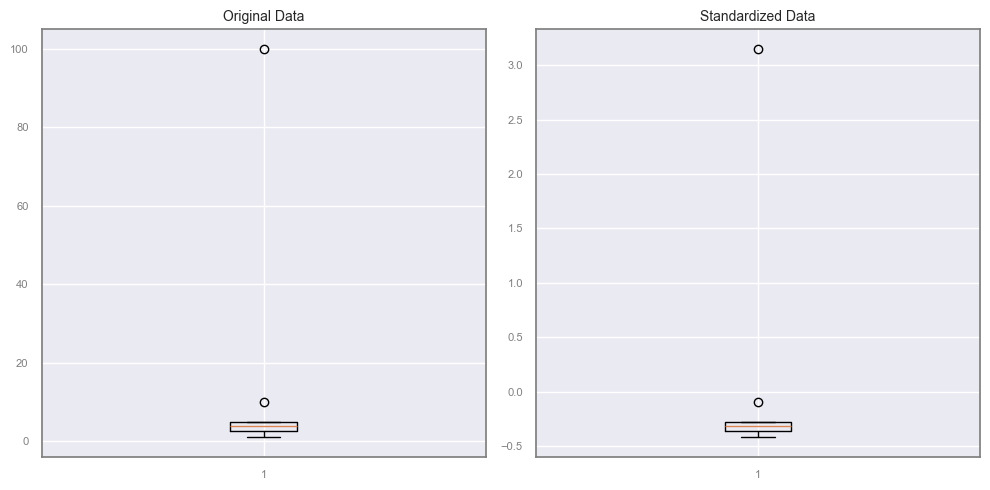

In [603]:
# Generate a dataset with outliers
data = np.array([1, 2, 2, 3, 3, 4, 4, 5, 5, 10, 100]).reshape(-1, 1)

# Standardize the data
scaler              = StandardScaler()
standardized_data   = scaler.fit_transform(data)

# Plot boxplots of original and standardized data
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Original data boxplot
axes[0].boxplot(data)
axes[0].set_title('Original Data')

# Standardized data boxplot
axes[1].boxplot(standardized_data)
axes[1].set_title('Standardized Data')

plt.tight_layout()
plt.show()

### <font color='gold'>*Why might we choose **cosine distance** instead of Euclidean or Manhattan when comparing documents or other data where the **direction** of features matters more than their **size**?*</font>

<font color='plum'>

**Cosine distance** is often preferred over **Euclidean** or **Manhattan distance** when comparing documents or other high-dimensional data where **direction matters more than magnitude**. 

#### What is Cosine Distance?
Cosine distance measures the **angle** between two vectors, not their magnitude. It’s defined as:

$$
\text{Cosine similarity} = \frac{\vec{A} \cdot \vec{B}}{||\vec{A}|| \cdot ||\vec{B}||}
$$

Cosine **distance** is then:

$$
\text{Cosine distance} = 1 - \text{Cosine similarity}
$$

#### Why Use Cosine Distance for Documents?

1. Magnitude Doesn't Matter:
   - In document comparison, the number of times a word appears (frequency) can vary widely.
   - Two documents might use the same words but in different quantities. Cosine distance focuses on the **pattern of word usage**, not how many times each word appears.

2. Focus on Direction:
   - Cosine distance treats documents as vectors in a high-dimensional space (each dimension = a word).
   - It compares the **orientation** of these vectors, which reflects the **relative importance** of words rather than their absolute counts.

3. Normalization Built-In:
   - Since cosine similarity uses normalized vectors, it inherently adjusts for document length. This is crucial when comparing documents of different sizes.

#### Example:

Consider two documents:

- Doc A: "Data science is fun"
- Doc B: "Data science is very fun"

Even though Doc B has one extra word ("very"), the **direction** of the word frequency vector is similar to Doc A. Cosine similarity will be high, indicating they are similar, even though Euclidean or Manhattan distances might suggest otherwise due to the extra word.

####  Summary:

| Metric         | Sensitive to Magnitude? | Good for Text/Data with Directional Importance? |
|----------------|-------------------------|--------------------------------------------------|
| Euclidean      | ✅ Yes                  | ❌ No                                             |
| Manhattan      | ✅ Yes                  | ❌ No                                             |
| Cosine Distance| ❌ No                   | ✅ Yes                                            |


# Misc.

In [604]:
# feature_cols        = X.columns.tolist()

# for col in feature_cols:
   
#     # Columns with <= 2 unique values are considered binary/categorical and will be passed through.
#     if df_3a[col].nunique() > 2: # type: ignore
#         numeric_cols.append(col)
#     else:
#         categorical_cols.append(col)

# dict_outcome_diabetes = {
#     0: 'No Diabetes',
#     1: 'Pre-/Diabetes'
# }

# print("\n--- Feature Classification Summary ---")
# print(f"Total Features: {len(feature_cols)}")
# print(f"Numeric Features (to be scaled): {numeric_cols}")
# print(f"Binary/Categorical Features (to be passed through): {categorical_cols}\n")

#### reorder_columns

In [605]:
# def reorder_columns(df: pd.DataFrame, col_names: list) -> pd.DataFrame:
#     missing_columns = set(col_names) - set(df.columns)
#     # if missing_columns:
#     #     raise ValueError(f"Missing columns: {missing_columns}")
    
#     for col in missing_columns:
#         df[col] = np.nan

#     df = df[col_names]
#     return df

#### null counts

In [606]:
# def show_null_counts_features(df: pd.DataFrame) -> pd.DataFrame:
#     """
#         Identifies and summarizes columns with missing values in given dataframe .

#         Steps performed:
#             1. Count Null Values: Calculates the total number of null values in each column.
#             2. Calculate Null Percentage: Computes the percentage of null values for each column, rounded to two decimal places.
#             3. Determine Feature Types: Identifies whether each column is numeric or categorical based on its data type.
#             4. Filter and Sort Columns: Filters out columns without missing values and sorts the remaining columns in descending order of their null percentage.
#             5. Display Summary: Prints the total number of samples in the dataset. If there are no null values, it informs the user. Otherwise, it prints a table summarizing the columns with missing values, including the feature name, number of null values, null percentage, and feature type.

#         Parameters:
#             df (pd.DataFrame): The DataFrame to analyze.

#         Returns:
#             pd.DataFrame: A DataFrame containing the columns with missing values, along with their null counts, null percentages, and feature types.
#     """
#     # Count the nulls and calculate the %
#     count_nulls  = df.isnull().sum()
#     df_nulls     = (df.isnull().mean() * 100).round(2)
    
#     # Determine if the column is numeric or non-numeric
#     feature_types = df.dtypes.apply(lambda x: 'Numeric' if np.issubdtype(x, np.number) else 'Categorical')
    
#     # Filter out the columns with missing values and sort them in descending order
#     missing_data = pd.DataFrame({
#         'Feature': count_nulls[count_nulls > 0].index,
#         '# Null Values': count_nulls[count_nulls > 0].values, 
#         'Null %': df_nulls[df_nulls > 0].values,
#         'Type': feature_types[count_nulls > 0].values
#     }).sort_values(by='Null %', ascending=False)
    
#     print(f'The dataset contains {len(df)} samples.\n')

#     if (len(missing_data) == 0):
#         print("There are no null values in the dataset!")
#     else:
#         # Print null value stats
#         print('Feature Name    # Nulls      Null %    Type')
#         print('------------    -------      ------    ----')
#         for index, row in missing_data.iterrows():
#             print(f"{row['Feature']:<15} {row['# Null Values']:<12} {row['Null %']:,.2f}%   {row['Type']}")

#     return missing_data